# Libraries

In [1]:
import numpy as np
import pickle
import os
# Change directory to the root of the folder (this script was launched from the subfolder python_scripts)
# All utils presuppose that we are working from the root directory of the github folder
os.chdir("../")
import sys
# Add utils directory in the list of directories to look for packages to import
sys.path.insert(0, os.path.join(os.getcwd(),'utils'))
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import pandas as pd
from datetime import datetime
import joblib
import gzip
import csv
import fnmatch
from nltk.stem import WordNetLemmatizer
from nltk.stem.snowball import SnowballStemmer
import cld3
from iso639 import languages
import re

In [2]:
# local utils
from powerlaw_regr import *
from analyse_sequence import *

In [3]:
# DEFAULT PARAMETERS IN THE FIGURES TO BE ADJUSTED!!!!

plt.style.use("default")

multiplicator = 4
width_fig = 5.70978 * multiplicator # default text width in Comnet is 5.70978
height_fig = width_fig * 2 / 3


params_default = {
    # no upper and right axes
    'axes.spines.right' : False,
    'axes.spines.top' : False,
    # no frame around the legend
    "legend.frameon" : False,

    # dimensions of figures and labels
    # we will play with these once we see how they are rendered in the latex
    'figure.figsize' : (width_fig, height_fig),

    'axes.labelsize' : 8 * multiplicator, #22,
    'axes.titlesize' : 8 * multiplicator, #25,
    'xtick.labelsize' : 6 * multiplicator, #18,
    'ytick.labelsize' : 6 * multiplicator, #18,
    'legend.fontsize' : 6 * multiplicator, #16,
    'font.size' : 8 * multiplicator,

    # no grids (?)
    'axes.grid' : False,

    # the default color(s) for lines in the plots: in order if multiple lines. We can change them or add colors if needed
#     'axes.prop_cycle' : mpl.cycler(color=["#00008B", "#BF0000", "#006400"]), 

    # default quality of the plot. Not too high but neither too low
    "savefig.dpi" : 100,
    "savefig.bbox" : 'tight', 
    
    'mathtext.fontset': 'stix',
    'font.family': 'STIXGeneral',
    
#     'text.usetex' : True,
#     'text.latex.preamble': r"\usepackage{amsmath}",
}

plt.rcParams.update(params_default)

In [4]:
def find_pattern(pattern, path):
    '''
        Finds all the paths inside path that are of the given pattern.

        E.g.: find_pattern("*.pkl", "./") to find all the files terminating with .pkl inside the current directory

        Returns the list of all such paths (empty is none is found).
    '''
    result = []
    for root, dirs, files in os.walk(path):
        for name in files:
            if fnmatch.fnmatch(name, pattern):
                result.append(os.path.join(root, name))
    return result


In [5]:
# prune text from punctuation and junk...
wnl = WordNetLemmatizer()
pattern = re.compile(r'\B#\w*[A-Za-z]+\w*|\b\w*[A-Za-z]+\w*', re.UNICODE)
def lemmatize(doc):
    '''
        Takes a string doc and returns the list of words, without punctuation and junk
    '''
    l = [wnl.lemmatize(t) for t in pattern.findall(doc)]
    return [w.lower() for w in l if len(w) > 1]

# Last.fm - 1k (O.Celma)

## 1st processing: time ordering

In [9]:
file_path = "./data/ocelma-dataset/lastfm-dataset-1K/userid-timestamp-artid-artname-traid-traname.tsv"

In [ ]:
df_lastfm = pd.read_csv(file_path, sep="\t", 
#                       converters={'timestamp':pd.to_datetime},
#                       parse_dates=['timestamp'],
#                       date_parser=my_date_parser,
#                       infer_datetime_format=True, date_parser=["timestamp"],
                      error_bad_lines=False, quoting=3, lineterminator="\n", 
                names=["userid", "timestamp", "musicbrainz-artist-id", "artist-name", "musicbrainz-track-id", "track-name"])

In [ ]:
my_format="%Y-%m-%dT%H:%M:%SZ"


def lookup(date_pd_series, format=None):
    """
    This is mostly useful for repeated timestamps, otherwise mostly useless.
    This is an extremely fast approach to datetime parsing.
    For large data, the same dates are often repeated. Rather than
    re-parse these, we store all unique dates, parse them, and
    use a lookup to convert all dates.
    """
    dates = {date:pd.to_datetime(date, format=format) for date in tqdm(date_pd_series.unique())}
    return date_pd_series.map(dates)
df_lastfm['timestamp'] = lookup(df_lastfm['timestamp'], format=my_format)

In [93]:
df_lastfm.iloc[7727675]

userid                                            user_000405
timestamp                                2010-08-13T23:06:38Z
musicbrainz-artist-id    5f572b31-8fd9-45ae-9beb-358c98d839df
artist-name                                 The Dandy Warhols
musicbrainz-track-id     223f9324-3546-446b-96a2-5f663192dd42
track-name                                              Sleep
Name: 7727675, dtype: object

In [94]:
df_lastfm.iloc[14343563]

userid                                            user_000762
timestamp                                2013-09-29T18:32:04Z
musicbrainz-artist-id    d8354b38-e942-4c89-ba93-29323432abc3
artist-name                                30 Seconds To Mars
musicbrainz-track-id     b5b40605-5a81-46b4-a51e-2b1ec7964c1a
track-name                                    A Beautiful Lie
Name: 14343563, dtype: object

In [76]:
with open("./data/ocelma-dataset/lastfm-dataset-1K/df_orig.pkl", "wb") as fp:
    joblib.dump(df_lastfm, fp)

In [86]:
df_lastfm = df_lastfm.sort_values(['timestamp', "userid"])

In [87]:
df_lastfm.head()

,userid,timestamp,musicbrainz-artist-id,artist-name,musicbrainz-track-id,track-name
7589788,user_000391,2005-02-14 00:00:07,fbd86487-ccb5-4a57-a860-cc3d360b5115,Starsailor,6b4977f4-3c7a-492a-af61-1e877fa66f52,Love Is Here
16931166,user_000871,2005-02-14 00:00:38,b3a6ebdf-4ee6-4ec0-912c-be03ade6c833,Sui Generis,9ecc2ab3-7294-43ad-bdeb-f51388a7a6e0,Rasguña Las Piedras
13542781,user_000709,2005-02-14 00:01:44,b4d32cff-f19e-455f-86c4-f347d824ca61,Eurythmics,1d0f1ea5-0a92-4578-a7e7-3f2a7129da61,Love Is A Stranger
5604026,user_000285,2005-02-14 00:02:10,95e1ead9-4d31-4808-a7ac-32c3614c116b,The Killers,46909ba9-46c7-461e-a2ef-280eacd550e4,Jenny Was A Friend Of Mine
2882463,user_000142,2005-02-14 00:02:40,51086134-0896-4c00-b54a-c5c37aeaf2bf,Anton Maiden,14025355-94c2-4e9b-b63f-c16cab9e8086,Revelations


In [96]:
df_lastfm.tail(20)

,userid,timestamp,musicbrainz-artist-id,artist-name,musicbrainz-track-id,track-name
12052920,user_000650,2009-06-19 20:34:15,cd84f520-7cd7-4e47-8cab-7beeceec3210,Alyson,NaN,Here With Me
18503194,user_000960,2009-06-19 20:35:33,299278d3-25dd-4f30-bae4-5b571c28034d,The Postal Service,NaN,Umbrella
18503193,user_000960,2009-06-19 20:40:16,0c751690-c784-4a4f-b1e4-c1de27d47581,Animal Collective,50f16fa4-501b-4883-8932-fb273238947c,Grass
13793249,user_000724,2009-06-19 20:42:49,f91e3a88-24ee-4563-8963-fab73d2765ed,Franz Schubert,2f685a84-9745-447c-a3a0-8f1d107bc7c2,"Piano Sonata No.20 In A, D.959: Ii. Andantino"
18503192,user_000960,2009-06-19 20:43:18,0039c7ae-e1a7-4a7d-9b49-0cbc716821a6,Death Cab For Cutie,5e26d283-96c1-4fbc-a24c-9866953f563c,I Will Possess Your Heart
13793248,user_000724,2009-06-19 20:50:23,f91e3a88-24ee-4563-8963-fab73d2765ed,Franz Schubert,bd2ff722-fa0b-4090-accb-1fec7b429bb7,"Piano Sonata No.20 In A, D.959: Iii. Scherzo (..."
18503191,user_000960,2009-06-19 20:51:53,28b2fb52-a83a-40ec-8617-6436e26eb3fd,Apostle Of Hustle,ca734922-ffc2-41be-8d53-5bdc15be90e2,¡Rafaga!
16392625,user_000842,2009-06-19 20:55:45,f91e3a88-24ee-4563-8963-fab73d2765ed,Franz Schubert,91aedc56-8a2d-4ca2-96b9-8d014ab92b94,"Piano Sonata No.20 In A, D.959: Iv. Rondo (All..."
18503190,user_000960,2009-06-19 20:55:51,299278d3-25dd-4f30-bae4-5b571c28034d,The Postal Service,NaN,Take A Look At Me Now
18503189,user_000960,2009-06-19 21:00:06,9a58fda3-f4ed-4080-a3a5-f457aac9fcdd,Joy Division,f83d07eb-05d0-4d7b-a4a4-4139b6815ce2,Atrocity Exhibition


In [90]:
print(df_lastfm.iloc[0]["timestamp"], df_lastfm.iloc[1]["timestamp"] )
print(df_lastfm.iloc[-1]["timestamp"], df_lastfm.iloc[-2]["timestamp"] )

2005-02-14 00:00:07 2005-02-14 00:00:38
2013-09-29 18:32:04 2010-08-13 23:06:38


In [95]:
with open("./data/ocelma-dataset/lastfm-dataset-1K/df_time_ordered.pkl", "wb") as fp:
    joblib.dump(df_lastfm, fp)

In [42]:
df = df.reset_index(drop=True)

In [43]:
df_lastfm = df_lastfm.drop([19150866,19150867])

In [44]:
df_lastfm

,userid,timestamp,musicbrainz-artist-id,artist-name,musicbrainz-track-id,track-name
0,user_000391,2005-02-14 00:00:07,fbd86487-ccb5-4a57-a860-cc3d360b5115,Starsailor,6b4977f4-3c7a-492a-af61-1e877fa66f52,Love Is Here
1,user_000871,2005-02-14 00:00:38,b3a6ebdf-4ee6-4ec0-912c-be03ade6c833,Sui Generis,9ecc2ab3-7294-43ad-bdeb-f51388a7a6e0,Rasguña Las Piedras
2,user_000709,2005-02-14 00:01:44,b4d32cff-f19e-455f-86c4-f347d824ca61,Eurythmics,1d0f1ea5-0a92-4578-a7e7-3f2a7129da61,Love Is A Stranger
3,user_000285,2005-02-14 00:02:10,95e1ead9-4d31-4808-a7ac-32c3614c116b,The Killers,46909ba9-46c7-461e-a2ef-280eacd550e4,Jenny Was A Friend Of Mine
4,user_000142,2005-02-14 00:02:40,51086134-0896-4c00-b54a-c5c37aeaf2bf,Anton Maiden,14025355-94c2-4e9b-b63f-c16cab9e8086,Revelations
...,...,...,...,...,...,...
19150861,user_000960,2009-06-19 21:18:26,09037f07-42bc-46ac-a1ee-37f834451fee,Minor Threat,5ec37b8c-1e83-46b2-8c6f-83f4923435a7,No Reason
19150862,user_000960,2009-06-19 21:20:24,3f542031-b054-454d-b57b-812fa2a81b11,Yo La Tengo,9fb737f7-dc19-452d-983e-83812612b3b5,A Worrying Thing
19150863,user_000960,2009-06-19 21:23:17,0039c7ae-e1a7-4a7d-9b49-0cbc716821a6,Death Cab For Cutie,4e17b118-70a6-4c1f-b326-b4ce91fd3fad,Soul Meets Body
19150864,user_000960,2009-06-19 21:27:08,5cbef01b-cc35-4f52-af7b-d0df0c4f61b9,Sonic Youth,af847770-3a91-4ecd-912c-ce154b5fce6a,Superstar


In [45]:
with open("./data/ocelma-dataset/lastfm-dataset-1K/df_time_ordered_clean.pkl", "wb") as fp:
    joblib.dump(df_lastfm, fp)

Last two rows must be dropped. Also this dataframe has a time interval different than the one said by the author on the website.

TODO: do calc on all and on single users of D and D2, as in UMT. Also check analytical data loaded into G.Drive

## 2nd processing: indexing tracks and artists

In [39]:
with open("./data/ocelma-dataset/lastfm-dataset-1K/df_time_ordered_clean.pkl", "rb") as fp:
    df_lastfm = joblib.load(fp)

In [45]:
artists = df_lastfm[["musicbrainz-artist-id","artist-name"]]

artists_unique = artists.drop_duplicates()

artists_unique = artists_unique.reset_index(drop=True)

In [46]:
unique_artists_remap = {}
for i in tqdm(range(len(artists_unique))):
    row = artists_unique.loc[i]
    artist_id = row["musicbrainz-artist-id"]
    if not pd.notna(artist_id):
        artist_id = None
    artist_name = row["artist-name"]
    if not pd.notna(artist_name):
        artist_name = None
    unique_artists_remap[(artist_id,artist_name)] = i

100%|██████████| 177023/177023 [00:24<00:00, 7298.38it/s]


In [40]:
tracks = df_lastfm[["musicbrainz-track-id","track-name","musicbrainz-artist-id","artist-name"]]

In [41]:
tracks_unique = tracks.drop_duplicates()

In [42]:
tracks_unique = tracks_unique.reset_index(drop=True)
# tracks_unique["index"] = tracks_unique.

In [86]:
# unique_tracks_remap = {}
# for i in tqdm(range(len(tracks_unique))):
#     row = tracks_unique.loc[i]
#     unique_tracks_remap[(row["musicbrainz-track-id"],row["track-name"],row["musicbrainz-artist-id"],row["artist-name"])] = i

In [48]:
unique_tracks_remap = {}
for i in tqdm(range(len(tracks_unique))):
    row = tracks_unique.loc[i]
    track_id = row["musicbrainz-track-id"]
    if not pd.notna(track_id):
        track_id = None
    track_name = row["track-name"]
    if not pd.notna(track_name):
        track_name = None
    artist_id = row["musicbrainz-artist-id"]
    if not pd.notna(artist_id):
        artist_id = None
    artist_name = row["artist-name"]
    if not pd.notna(artist_name):
        artist_name = None
    artist_id_remapped = unique_artists_remap[(artist_id,artist_name)]
    unique_tracks_remap[(track_id,track_name,artist_id_remapped)] = i

100%|██████████| 1505514/1505514 [03:45<00:00, 6662.75it/s]


In [49]:
df_lastfm2 = df_lastfm[["userid","timestamp"]]
track_id_remapped_list = -np.ones(len(df_lastfm2))
artist_id_remapped_list = -np.ones(len(df_lastfm2))

In [50]:
for i in tqdm(range(len(df_lastfm))):
    row = df_lastfm.loc[i]
    track_id = row["musicbrainz-track-id"]
    if not pd.notna(track_id):
        track_id = None
    track_name = row["track-name"]
    if not pd.notna(track_name):
        track_name = None
    artist_id = row["musicbrainz-artist-id"]
    if not pd.notna(artist_id):
        artist_id = None
    artist_name = row["artist-name"]
    if not pd.notna(artist_name):
        artist_name = None
    artist_id_remapped = unique_artists_remap[(artist_id,artist_name)]
    artist_id_remapped_list[i] = artist_id_remapped
    track_id_remapped_list[i] = unique_tracks_remap[(track_id,track_name,artist_id_remapped)]

100%|██████████| 19150866/19150866 [1:28:24<00:00, 3610.16it/s]


In [51]:
df_lastfm2["track_id_remapped"] = track_id_remapped_list.copy()
df_lastfm2["artist_id_remapped"] = artist_id_remapped_list.copy()

/tmp/2049703.1.all.q/ipykernel_20116/1589433352.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2["track_id_remapped"] = track_id_remapped_list.copy()
/tmp/2049703.1.all.q/ipykernel_20116/1589433352.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2["artist_id_remapped"] = artist_id_remapped_list.copy()


In [52]:
with open("./data/ocelma-dataset/lastfm-dataset-1K/remap_artists.pkl", "wb") as fp:
    joblib.dump(unique_artists_remap, fp)
with open("./data/ocelma-dataset/lastfm-dataset-1K/remap_tracks.pkl", "wb") as fp:
    joblib.dump(unique_tracks_remap, fp)

In [53]:
with open("./data/ocelma-dataset/lastfm-dataset-1K/df_indexed.pkl", "wb") as fp:
    joblib.dump(df_lastfm2, fp)

In [54]:
df_lastfm = df_lastfm2.copy()

## 3rd processing: creation of individual sequences

In [281]:
with open("./data/ocelma-dataset/lastfm-dataset-1K/df_indexed.pkl", "rb") as fp:
    df_lastfm = joblib.load(fp)

In [282]:
users_list = list(df_lastfm["userid"].unique())
users_list.sort()
print(len(users_list), max(users_list))

992 user_001000


In [283]:
df_lastfm

,userid,timestamp,track_id_remapped,artist_id_remapped
0,user_000391,2005-02-14 00:00:07,0.0,0.0
1,user_000871,2005-02-14 00:00:38,1.0,1.0
2,user_000709,2005-02-14 00:01:44,2.0,2.0
3,user_000285,2005-02-14 00:02:10,3.0,3.0
4,user_000142,2005-02-14 00:02:40,4.0,4.0
...,...,...,...,...
19150861,user_000960,2009-06-19 21:18:26,73214.0,2842.0
19150862,user_000960,2009-06-19 21:20:24,117991.0,2228.0
19150863,user_000960,2009-06-19 21:23:17,103131.0,126.0
19150864,user_000960,2009-06-19 21:27:08,25733.0,346.0


In [284]:
users = {}
for userid in users_list:
    users[userid] = {"sequence_tracks":[], "sequence_artists":[], "sequence_timestamps":[]}

In [ ]:
for i in tqdm(range(len(df_lastfm))):
    row = df_lastfm.loc[i]
    userid = row["userid"]
    if not pd.notna(userid):
        print(f"Row {i}: userid None")
        userid = None
    timestamp = row["timestamp"]
    if not pd.notna(timestamp):
        print(f"Row {i}: timestamp None")
        timestamp = None
    track_id = row["track_id_remapped"]
    if not pd.notna(track_id):
        print(f"Row {i}: track_id None")
        track_id = None
    artist_id = row["artist_id_remapped"]
    if not pd.notna(artist_id):
        print(f"Row {i}: artist_id None")
        artist_id = None
    users[userid]["sequence_tracks"].append(track_id)
    users[userid]["sequence_artists"].append(artist_id)
    users[userid]["sequence_timestamps"].append(timestamp)

In [63]:
for userid in tqdm(users_list):
    users[userid]["sequence_tracks"] = np.array(users[userid]["sequence_tracks"],dtype=int)
    users[userid]["sequence_artists"] = np.array(users[userid]["sequence_artists"],dtype=int)
    users[userid]["sequence_timestamps"] = np.array(users[userid]["sequence_timestamps"])

100%|██████████| 992/992 [00:00<00:00, 14418.21it/s]


In [64]:
i = users_list[0]
print(users[i]["sequence_tracks"][:20])
print(users[i]["sequence_tracks"][-20:])
print(users[i]["sequence_artists"][:20])
print(users[i]["sequence_artists"][-20:])
print(users[i]["sequence_timestamps"][:20])
print(users[i]["sequence_timestamps"][-20:])

[447195 447199 447208 447212 447213 447218  79351  70436   2677 410222
 447267 447272 447276  63867 314911  73796 352588 108352 447301  41303]
[1456541  514060   53426 1251851 1161644 1161658 1477073 1477076 1477082
  241971 1477101 1477242 1476972 1476987 1476992 1477268 1476995 1477004
 1477011 1496528]
[55741 55741 55741  6657 14330  7290  7290   284   299  4638 55749 20455
 55750   464   464   779 12480   407 17380  1691]
[169814  16914   9673    323   1139   1139   6625   6625   6625   6625
   6625   6625   6625   6625   6625   6625   6625   6625   6625   2969]
[Timestamp('2006-08-13 13:59:20') Timestamp('2006-08-13 14:03:29')
 Timestamp('2006-08-13 14:10:43') Timestamp('2006-08-13 14:17:40')
 Timestamp('2006-08-13 14:19:06') Timestamp('2006-08-13 14:23:03')
 Timestamp('2006-08-13 14:44:23') Timestamp('2006-08-13 14:55:14')
 Timestamp('2006-08-13 14:59:59') Timestamp('2006-08-13 15:05:20')
 Timestamp('2006-08-13 15:07:25') Timestamp('2006-08-13 15:12:12')
 Timestamp('2006-08-13 15

In [291]:
with gzip.open("./data/ocelma-dataset/lastfm-dataset-1K/users.pkl.gz", "wb") as fp:
    joblib.dump(users, fp)

In [290]:
with gzip.open("./data/ocelma-dataset/lastfm-dataset-1K/users.pkl.gz", "rb") as fp:
    users = joblib.load(fp)

In [292]:
min_len_sequence = 1000
# filtering on all users with at least 1000 elements in the sequence
users_list_filtered = []
for userid in tqdm(users_list):
    if len(users[userid]["sequence_tracks"]) < min_len_sequence:
        del users[userid]
    else:
        users_list_filtered.append(userid)
print("Kept %d out of %d"%(len(users_list_filtered), len(users_list)))

  0%|          | 0/992 [00:00<?, ?it/s]

Kept 890 out of 992


In [293]:
# from now on this will be used instead
with gzip.open("./data/ocelma-dataset/lastfm-dataset-1K/users_min_1000.pkl.gz", "wb") as fp:
    joblib.dump(users, fp)

In [294]:
users_list = users_list_filtered

In [17]:
# from now on this will be used instead
with gzip.open("./data/ocelma-dataset/lastfm-dataset-1K/users_list_min_1000.pkl.gz", "wb") as fp:
    joblib.dump(users_list, fp)

## Analysis

In [6]:
with gzip.open("./data/ocelma-dataset/lastfm-dataset-1K/users_min_1000.pkl.gz", "rb") as fp:
    users = joblib.load(fp)

In [14]:
users_list = list(users.keys())
users_list.sort()
print(len(users_list), max(users_list))

890 user_001000


In [15]:
# Just a check here
# If there is a sequence_labels with max counts of each labels = 2 there might be a problem during entropy calculation!
for userid in tqdm(users_list):
    sequence_labels = users[userid]["sequence_artists"]
    labels_freq = {}
    for t,label in enumerate(sequence_labels):
        if label not in labels_freq:
            labels_freq[label] = 1
        else:
            labels_freq[label] += 1
    if max(list(labels_freq.values())) < 10:
        print(userid,max(list(labels_freq.values())))

  0%|          | 0/890 [00:00<?, ?it/s]

### Individual analysis

In [ ]:
# userid = users_list[60]
results_light_individual_lastfm = {} 
for userid in tqdm(users_list):
    sequence = users[userid]["sequence_tracks"]
    sequence_labels = users[userid]["sequence_artists"]
    save_light_file_path = f"./data/ocelma-dataset/lastfm-dataset-1K/individual_results_light/{userid}_light.pkl"
    save_all_file_path = f"./data/ocelma-dataset/lastfm-dataset-1K/individual_results/{userid}.pkl"
    results_light_individual_lastfm[userid] = analyse_sequence(sequence, num_to_save=1000, find_novelties = True, 
                         calculate_entropies_original = False, calculate_entropies_labels = True,
                         D=None, D2=None, D3=None, D4=None, sequence_labels = sequence_labels,
                         save_all=True, save_all_file_path = save_all_file_path, 
                         save_light_file_path = save_light_file_path,
                         calculate_beta_loglogregr_indices = False,
                         do_prints = False, return_all = False)

  0%|          | 0/890 [00:00<?, ?it/s]

/data/home/ahw701/env_enrico/envs/gt/lib/python3.9/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


In [ ]:
print("FINISHED")

In [60]:
with gzip.open("./data/ocelma-dataset/lastfm-dataset-1K/results_light_users_lastfm.pkl.gz", "wb") as fp:
    joblib.dump(results_light_individual_lastfm, fp)

In [61]:
# USE THIS TIME THE SEQUENCE OF ARTISTS FOR THE SEQUENCES
results_light_individual_lastfm = {} 
for userid in tqdm(users_list):
    sequence = users[userid]["sequence_artists"]
    sequence_labels = users[userid]["sequence_artists"]
    save_light_file_path = f"./data/ocelma-dataset/lastfm-dataset-1K/individual_results_artists_light/{userid}_light.pkl"
    save_all_file_path = f"./data/ocelma-dataset/lastfm-dataset-1K/individual_results_artists/{userid}.pkl"
    results_light_individual_lastfm[userid] = analyse_sequence(sequence, num_to_save=1000, find_novelties = True, 
                         calculate_entropies_original = False, calculate_entropies_labels = True,
                         D=None, D2=None, D3=None, D4=None, sequence_labels = sequence_labels,
                         save_all=True, save_all_file_path = save_all_file_path, 
                         save_light_file_path = save_light_file_path,
                         calculate_beta_loglogregr_indices = False,
                         do_prints = False, return_all = False)

  0%|          | 0/890 [00:00<?, ?it/s]

In [62]:
with gzip.open("./data/ocelma-dataset/lastfm-dataset-1K/results_light_users_lastfm_artists.pkl.gz", "wb") as fp:
    joblib.dump(results_light_individual_lastfm, fp)

In [63]:
with gzip.open("./data/ocelma-dataset/lastfm-dataset-1K/results_light_users_lastfm.pkl.gz", "rb") as fp:
    results_light_individual_lastfm = joblib.load(fp)

### Check users Heaps'

In [64]:
with gzip.open("./data/ocelma-dataset/lastfm-dataset-1K/results_light_users_lastfm.pkl.gz", "rb") as fp:
    results_light_individual_lastfm = joblib.load(fp)

In [65]:
with gzip.open("./data/ocelma-dataset/lastfm-dataset-1K/users_min_1000.pkl.gz", "rb") as fp:
    users = joblib.load(fp)

In [66]:
users_list = list(users.keys())
users_list.sort()
print(len(users_list), max(users_list))

890 user_001000


In [67]:
users['user_000001'].keys()

dict_keys(['sequence_tracks', 'sequence_artists', 'sequence_timestamps'])

In [68]:
results = {}
for userid in users_list:
    try:
        save_all_file_path = f"./data/ocelma-dataset/lastfm-dataset-1K/individual_results/{userid}.pkl"
        with open(save_all_file_path, 'rb') as fp:
            user_result = joblib.load(fp)
        results[userid] = user_result
    except:
        pass
print(user_result.keys())

dict_keys(['D', 'D2', 'D3', 'D4', 'ts', 'indices', 'ts_geom', 'indices_geom', 'D_indices', 'D2_indices', 'D3_indices', 'D4_indices', 'sequence', 'sequence_labels', 'entropies', 'entropies_glob', 'weighted_diff_entropies', 'entropies_sorted_keys', 'entropies_sorted_weights', 'mean_entropies', 'mean_entropies_glob', 'beta_mean_indices', 'beta2_mean_indices', 'beta3_mean_indices', 'beta4_mean_indices', 'beta_loglogregr_indices_geom', 'beta2_loglogregr_indices_geom', 'beta3_loglogregr_indices_geom', 'beta4_loglogregr_indices_geom'])


In [69]:
results_light_individual_lastfm[userid].keys()

dict_keys(['ts', 'indices', 'ts_geom', 'indices_geom', 'D_indices', 'D2_indices', 'D3_indices', 'D4_indices', 'weighted_diff_entropies', 'beta_mean_indices', 'beta2_mean_indices', 'beta3_mean_indices', 'beta4_mean_indices', 'beta_loglogregr_indices_geom', 'beta2_loglogregr_indices_geom', 'beta3_loglogregr_indices_geom', 'beta4_loglogregr_indices_geom'])

In [70]:
check_userid = [userid for userid in users_list if results_light_individual_lastfm[userid]['beta_loglogregr_indices_geom'][-1] > 1.2 and userid in results]

In [71]:
check_userid

[]

(array([ 1.,  0.,  0.,  0.,  2.,  0.,  1.,  0.,  0.,  1.,  0.,  2.,  0.,
         4.,  3.,  3.,  4.,  8.,  4., 10., 13., 12., 10., 20., 16., 23.,
        24., 30., 22., 42., 39., 33., 35., 44., 33., 37., 41., 49., 41.,
        43., 43., 28., 25., 32., 22., 34., 12., 15., 19., 10.]),
 array([0.59615778, 0.60415196, 0.61214614, 0.62014032, 0.6281345 ,
        0.63612867, 0.64412285, 0.65211703, 0.66011121, 0.66810539,
        0.67609957, 0.68409374, 0.69208792, 0.7000821 , 0.70807628,
        0.71607046, 0.72406464, 0.73205881, 0.74005299, 0.74804717,
        0.75604135, 0.76403553, 0.77202971, 0.78002388, 0.78801806,
        0.79601224, 0.80400642, 0.8120006 , 0.81999478, 0.82798895,
        0.83598313, 0.84397731, 0.85197149, 0.85996567, 0.86795984,
        0.87595402, 0.8839482 , 0.89194238, 0.89993656, 0.90793074,
        0.91592491, 0.92391909, 0.93191327, 0.93990745, 0.94790163,
        0.95589581, 0.96388998, 0.97188416, 0.97987834, 0.98787252,
        0.9958667 ]),
 <BarContainer

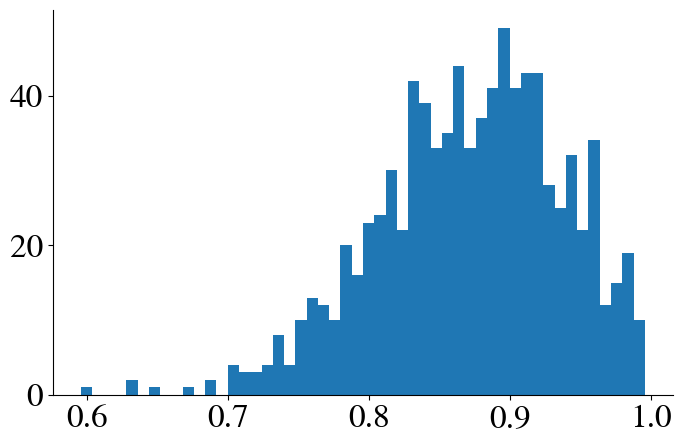

In [72]:
plt.figure(figsize=(8,5))
plt.hist([results_light_individual_lastfm[userid]['beta_loglogregr_indices_geom'][-1] for userid in users_list], bins=50)

In [73]:
len(check_userid)

0

In [74]:
colors=['blue','red','green','orange', 'magenta']

Text(0, 0.5, '$D(t)$')

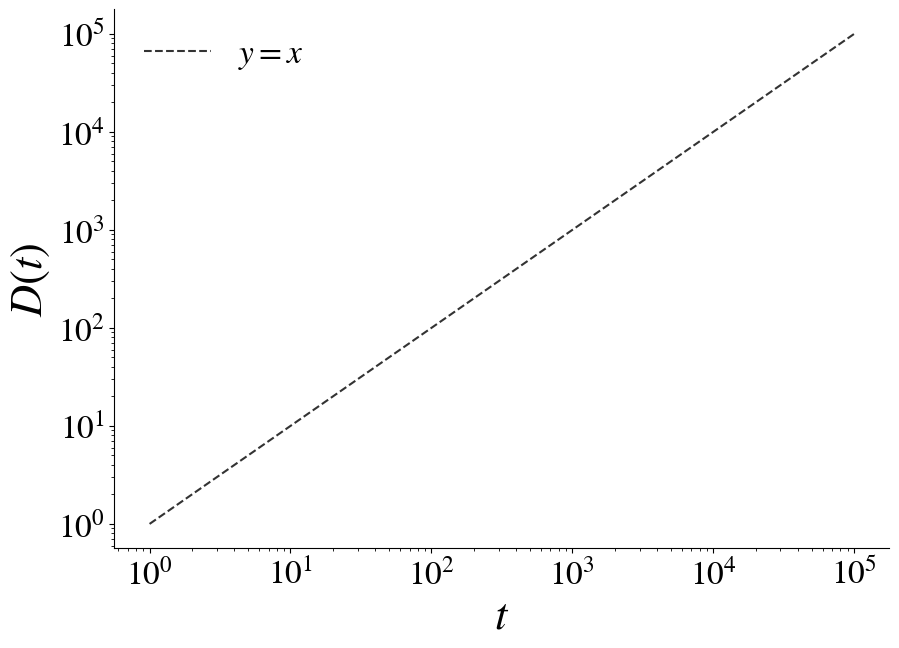

In [75]:
fig = plt.figure(figsize=(10,7))
ax = plt.gca()
ax.plot([1,10**5], [1,10**5],
        color = 'black', ls = "--", alpha=0.8, label = r"$y=x$")
    
for i,userid in enumerate(check_userid):
    ax.plot(results[userid]["ts"],results[userid]["D_indices"], color = colors[i])
    ax.plot(results[userid]["ts"],results[userid]["ts"]**results[userid]["beta_loglogregr_indices_geom"][-1] * (results[userid]["D_indices"][-1]/results[userid]["ts"][-1]**results[userid]["beta_loglogregr_indices_geom"][-1]), 
        color = colors[i], ls = "--", alpha=0.8, label = "%.3f"%results[userid]["beta_loglogregr_indices_geom"][-1])
ax.loglog()
ax.legend()
ax.set_xlabel(r'$t$')
ax.set_ylabel(r'$D(t)$')

In [76]:
t = np.arange(100,1000)
y = t - 100

In [77]:
t = np.arange(100,1000)
y2 = t**0.5

Text(0, 0.5, '$D(t)$')

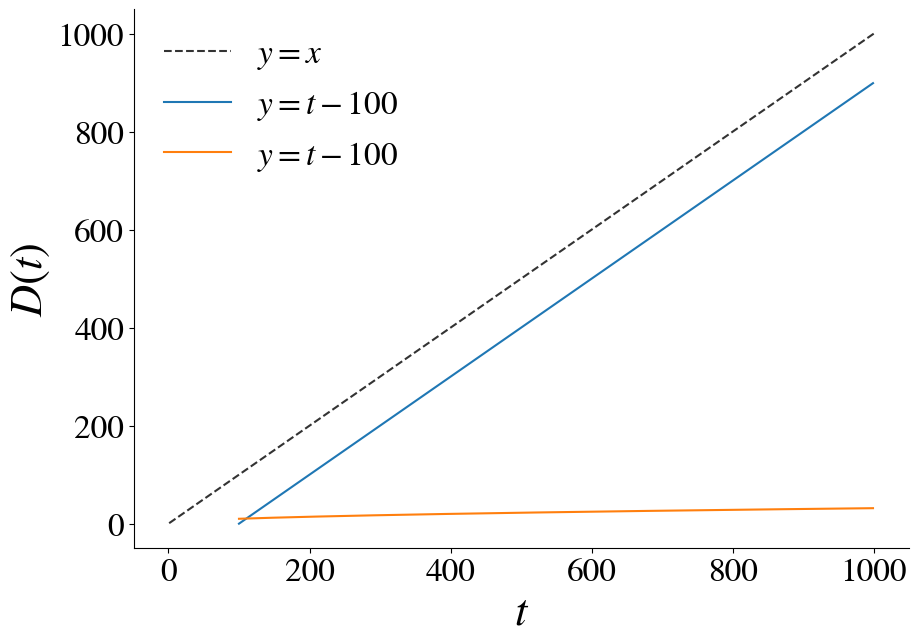

In [78]:
fig = plt.figure(figsize=(10,7))
ax = plt.gca()
ax.plot([1,10**3], [1,10**3],
        color = 'black', ls = "--", alpha=0.8, label = r"$y=x$")
ax.plot(t,y, label = r"$y = t - 100$")
ax.plot(t,y2, label = r"$y = t - 100$")
# ax.loglog()
ax.legend()
ax.set_xlabel(r'$t$')
ax.set_ylabel(r'$D(t)$')

In [79]:
import powerlaw

Text(0, 0.5, '$D(t)$')

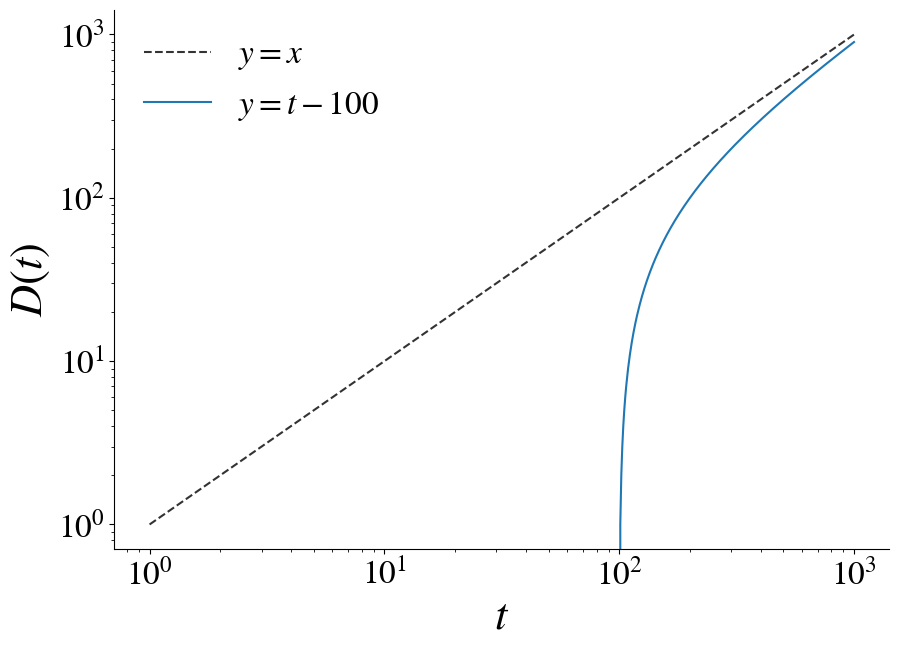

In [80]:
fig = plt.figure(figsize=(10,7))
ax = plt.gca()
ax.plot([1,10**3], [1,10**3],
        color = 'black', ls = "--", alpha=0.8, label = r"$y=x$")
ax.plot(t,y, label = r"$y = t - 100$")
ax.loglog()
ax.legend()
ax.set_xlabel(r'$t$')
ax.set_ylabel(r'$D(t)$')

In [89]:
data = [t[i] for i in range(len(t)) for _ in range(y[i])]

In [110]:
fit = powerlaw.Fit(data,xmin=100,xmax=1000,discrete=True)

In [119]:
fit = powerlaw.Fit(data,parameter_range={'alpha':(0,1)})

Calculating best minimal value for power law fit


No valid fits found.


In [114]:
data2 = [t[i] for i in range(len(t)) for _ in range(y2[i])]

TypeError: 'numpy.float64' object cannot be interpreted as an integer

In [ ]:
fit2 = powerlaw.Fit(data2,parameter_range={'alpha':(-2,0)})

In [103]:
fit = powerlaw.Fit(data,xmin=100,xmax=1000,discrete=True,parameter_range={'alpha':(None,None)})

AttributeError: 'Power_Law' object has no attribute 'parent_Fit'

In [96]:
fit.alpha

1.0000000050875804

In [95]:
fit.sigma

7.998806283595838e-12

In [79]:
print(fit.power_law.alpha)
print(fit.power_law.xmin)

37.71490033533836
947.0


(1, 1000)

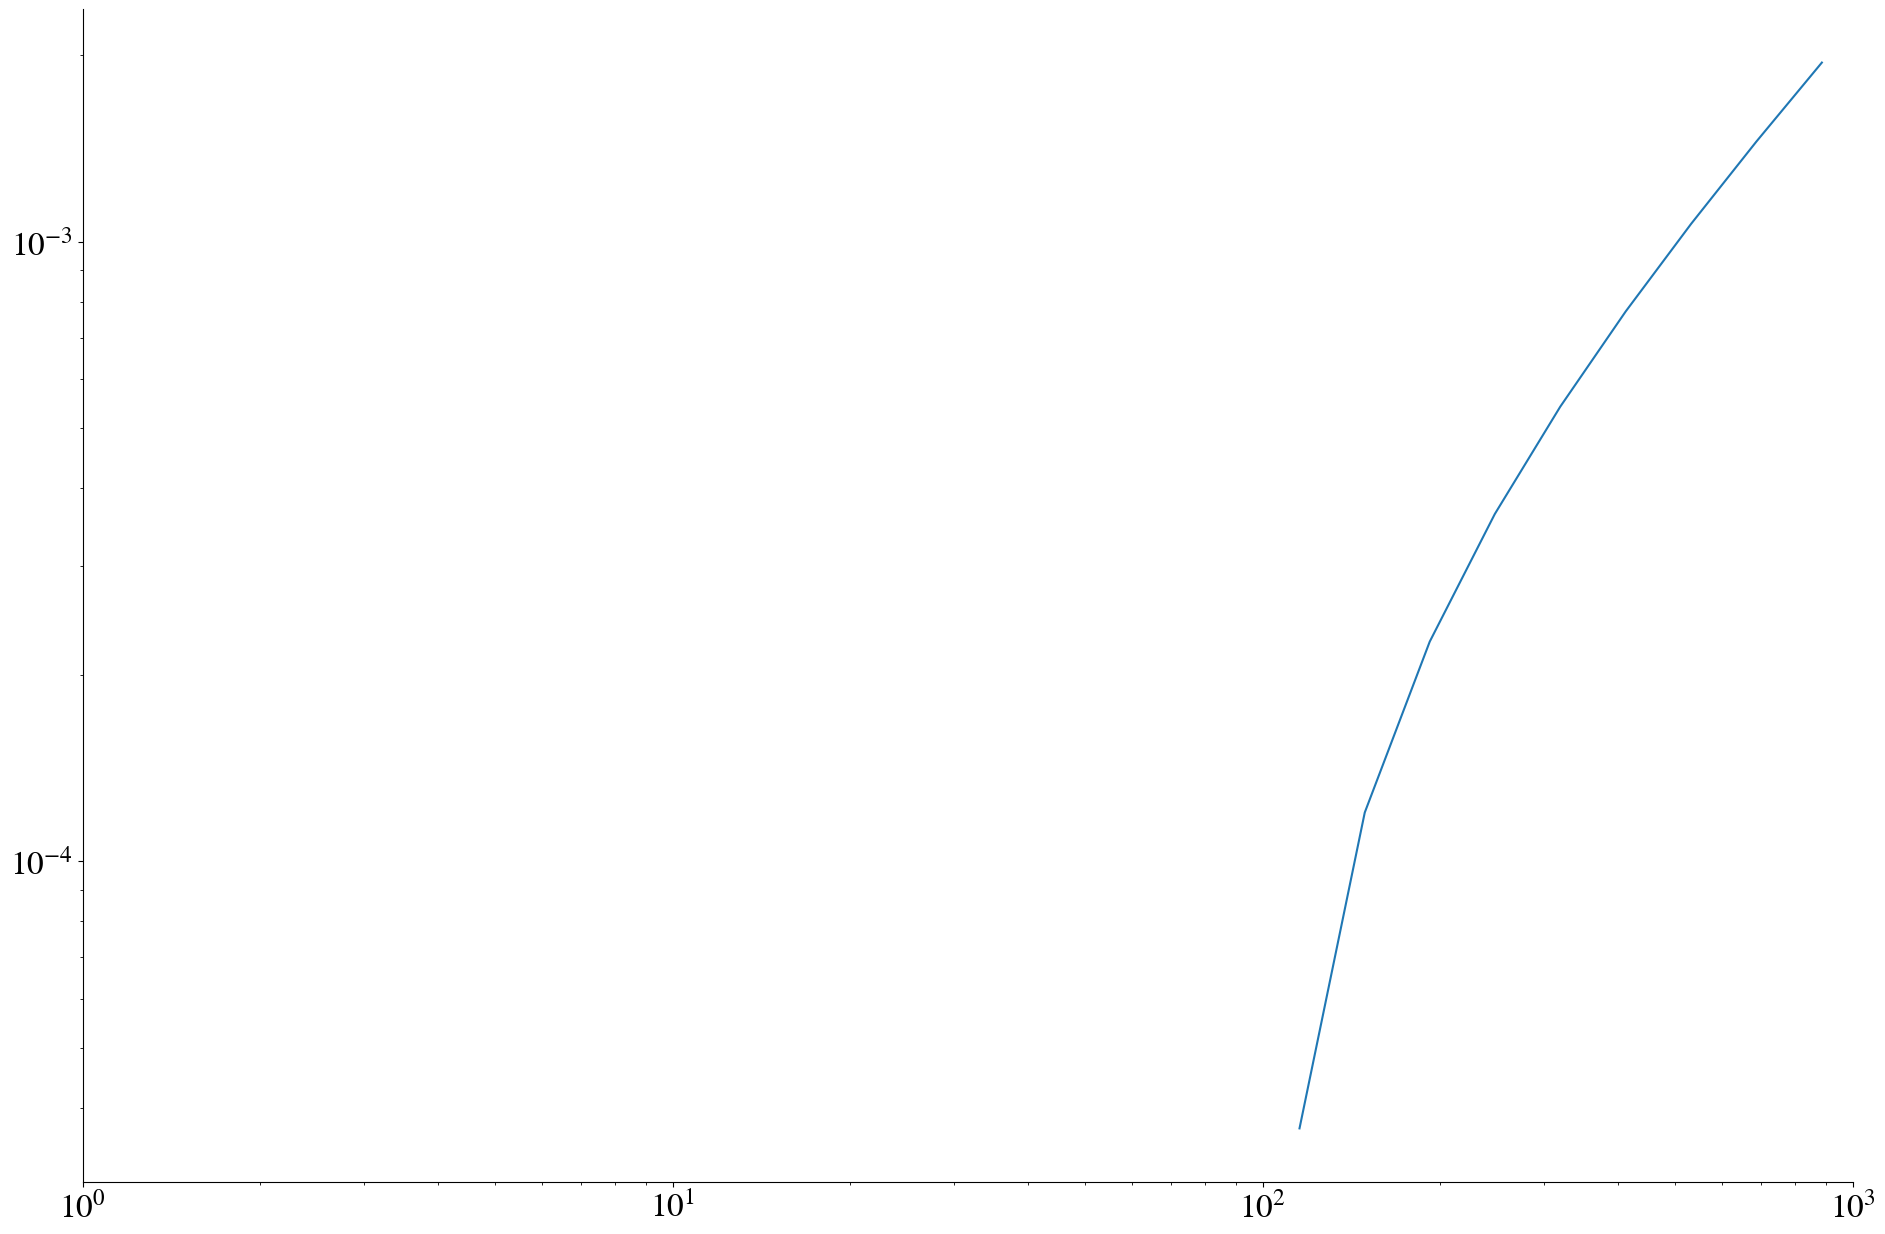

In [91]:
powerlaw.plot_pdf(data)
plt.xlim(1,1000)

In [86]:
R, p = fit.distribution_compare('lognormal_positive', 'lognormal')

Assuming nested distributions


In [85]:
fit.distribution_compare('lognormal', 'normal')

Assuming nested distributions


AttributeError: normal

In [87]:
R,p

(0.0, 1.0)

Text(0, 0.5, '$D(t)$')

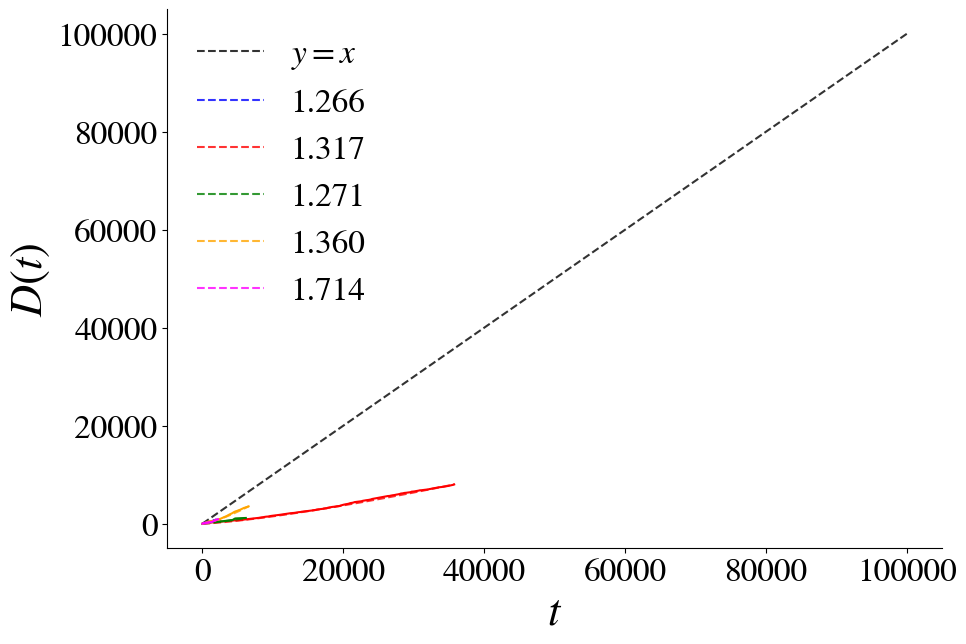

In [72]:
fig = plt.figure(figsize=(10,7))
ax = plt.gca()
ax.plot([1,10**5], [1,10**5],
        color = 'black', ls = "--", alpha=0.8, label = r"$y=x$")
    
for i,userid in enumerate(check_userid):
    ax.plot(results[userid]["ts"]+1,results[userid]["D_indices"], color = colors[i])
    ax.plot(results[userid]["ts"],results[userid]["ts"]**results[userid]["beta_loglogregr_indices_geom"][-1] * (results[userid]["D_indices"][-1]/results[userid]["ts"][-1]**results[userid]["beta_loglogregr_indices_geom"][-1]), 
        color = colors[i], ls = "--", alpha=0.8, label = "%.3f"%results[userid]["beta_loglogregr_indices_geom"][-1])
# ax.loglog()
ax.legend()
ax.set_xlabel(r'$t$')
ax.set_ylabel(r'$D(t)$')

In [59]:
results[userid]["ts"][0]

1

In [60]:
for userid in check_userid:
    user_result = results[userid]
    D = user_result['D']
    last_y = D[0]
    print(D[0])
    for t,y in enumerate(D):
        if y not in [last_y, last_y+1]:
            print(f"problem with {userid} at t={t}")
        last_y = y

1
1
1
1
1


In [65]:
user_result.keys()

dict_keys(['D', 'D2', 'D3', 'D4', 'ts', 'indices', 'ts_geom', 'indices_geom', 'D_indices', 'D2_indices', 'D3_indices', 'D4_indices', 'sequence', 'sequence_labels', 'entropies', 'entropies_glob', 'weighted_diff_entropies', 'entropies_sorted_keys', 'entropies_sorted_weights', 'mean_entropies', 'mean_entropies_glob', 'beta_mean_indices', 'beta2_mean_indices', 'beta3_mean_indices', 'beta4_mean_indices', 'beta_loglogregr_indices_geom', 'beta2_loglogregr_indices_geom', 'beta3_loglogregr_indices_geom', 'beta4_loglogregr_indices_geom'])

In [63]:
len(user_result['D'])

2204

In [64]:
len(user_result['ts'])

1257

In [62]:
len(user_result['D_indices'])

1257

In [66]:
user_result['indices']

[1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 24,
 25,
 26,
 27,
 28,
 29,
 30,
 31,
 32,
 33,
 34,
 35,
 36,
 37,
 38,
 39,
 40,
 41,
 42,
 43,
 44,
 45,
 46,
 47,
 48,
 49,
 50,
 51,
 52,
 53,
 54,
 55,
 56,
 57,
 58,
 59,
 60,
 61,
 62,
 63,
 64,
 65,
 66,
 67,
 68,
 69,
 70,
 71,
 72,
 73,
 74,
 75,
 76,
 77,
 78,
 79,
 80,
 81,
 82,
 83,
 84,
 85,
 86,
 87,
 88,
 89,
 90,
 91,
 92,
 93,
 94,
 95,
 96,
 97,
 98,
 99,
 100,
 101,
 102,
 103,
 104,
 105,
 106,
 107,
 108,
 109,
 110,
 111,
 112,
 113,
 114,
 115,
 116,
 117,
 118,
 119,
 120,
 121,
 122,
 123,
 124,
 125,
 126,
 127,
 128,
 129,
 130,
 131,
 132,
 133,
 134,
 135,
 136,
 137,
 138,
 139,
 140,
 141,
 142,
 144,
 145,
 146,
 147,
 148,
 149,
 150,
 151,
 153,
 154,
 155,
 156,
 157,
 159,
 160,
 161,
 162,
 164,
 165,
 166,
 168,
 169,
 170,
 171,
 172,
 173,
 174,
 175,
 177,
 178,
 179,
 180,
 181,
 182,
 183,
 184,
 185,
 186,
 187,
 188,
 190,
 191,
 192

In [33]:
len(user_result['beta_loglogregr_indices_geom']), len(results_light_individual_lastfm[userid]['beta_loglogregr_indices_geom'])

(606, 630)

In [550]:
for userid in tqdm(users_list):
    save_all_file_path = f"./data/ocelma-dataset/lastfm-dataset-1K/individual_results/{userid}.pkl"
    with open(save_all_file_path, 'rb') as fp:
        user_result = pickle.load(fp)
    if len(user_result['D']) > median_len_sequences:
        count += 1
        average_user['D'] += user_result['D'][:median_len_sequences]
        average_user['D2'] += user_result['D2'][:median_len_sequences]
        average_user['D3'] += user_result['D3'][:median_len_sequences]
        average_user['D4'] += user_result['D4'][:median_len_sequences]
average_user['D']  /= count
average_user['D2'] /= count
average_user['D3'] /= count
average_user['D4'] /= count
print(count)

  0%|          | 0/890 [00:00<?, ?it/s]

445


### Average individual analysis

In [157]:
with gzip.open("./data/ocelma-dataset/lastfm-dataset-1K/users_min_1000.pkl.gz", "rb") as fp:
    users = joblib.load(fp)

In [158]:
users['user_000001'].keys()

dict_keys(['sequence_tracks', 'sequence_artists', 'sequence_timestamps'])

In [159]:
min_len_sequence = 1000

890


  0%|          | 0/890 [00:00<?, ?it/s]

Excluding 0% len is 1021
Excluding 10% len is 2500
Excluding 20% len is 4530
Excluding 30% len is 7078
Excluding 40% len is 10297
Excluding 50% len is 13971
Excluding 60% len is 18354
Excluding 70% len is 23465
Excluding 80% len is 34738
Excluding 90% len is 48223
Excluding 100% len is 183103


[]

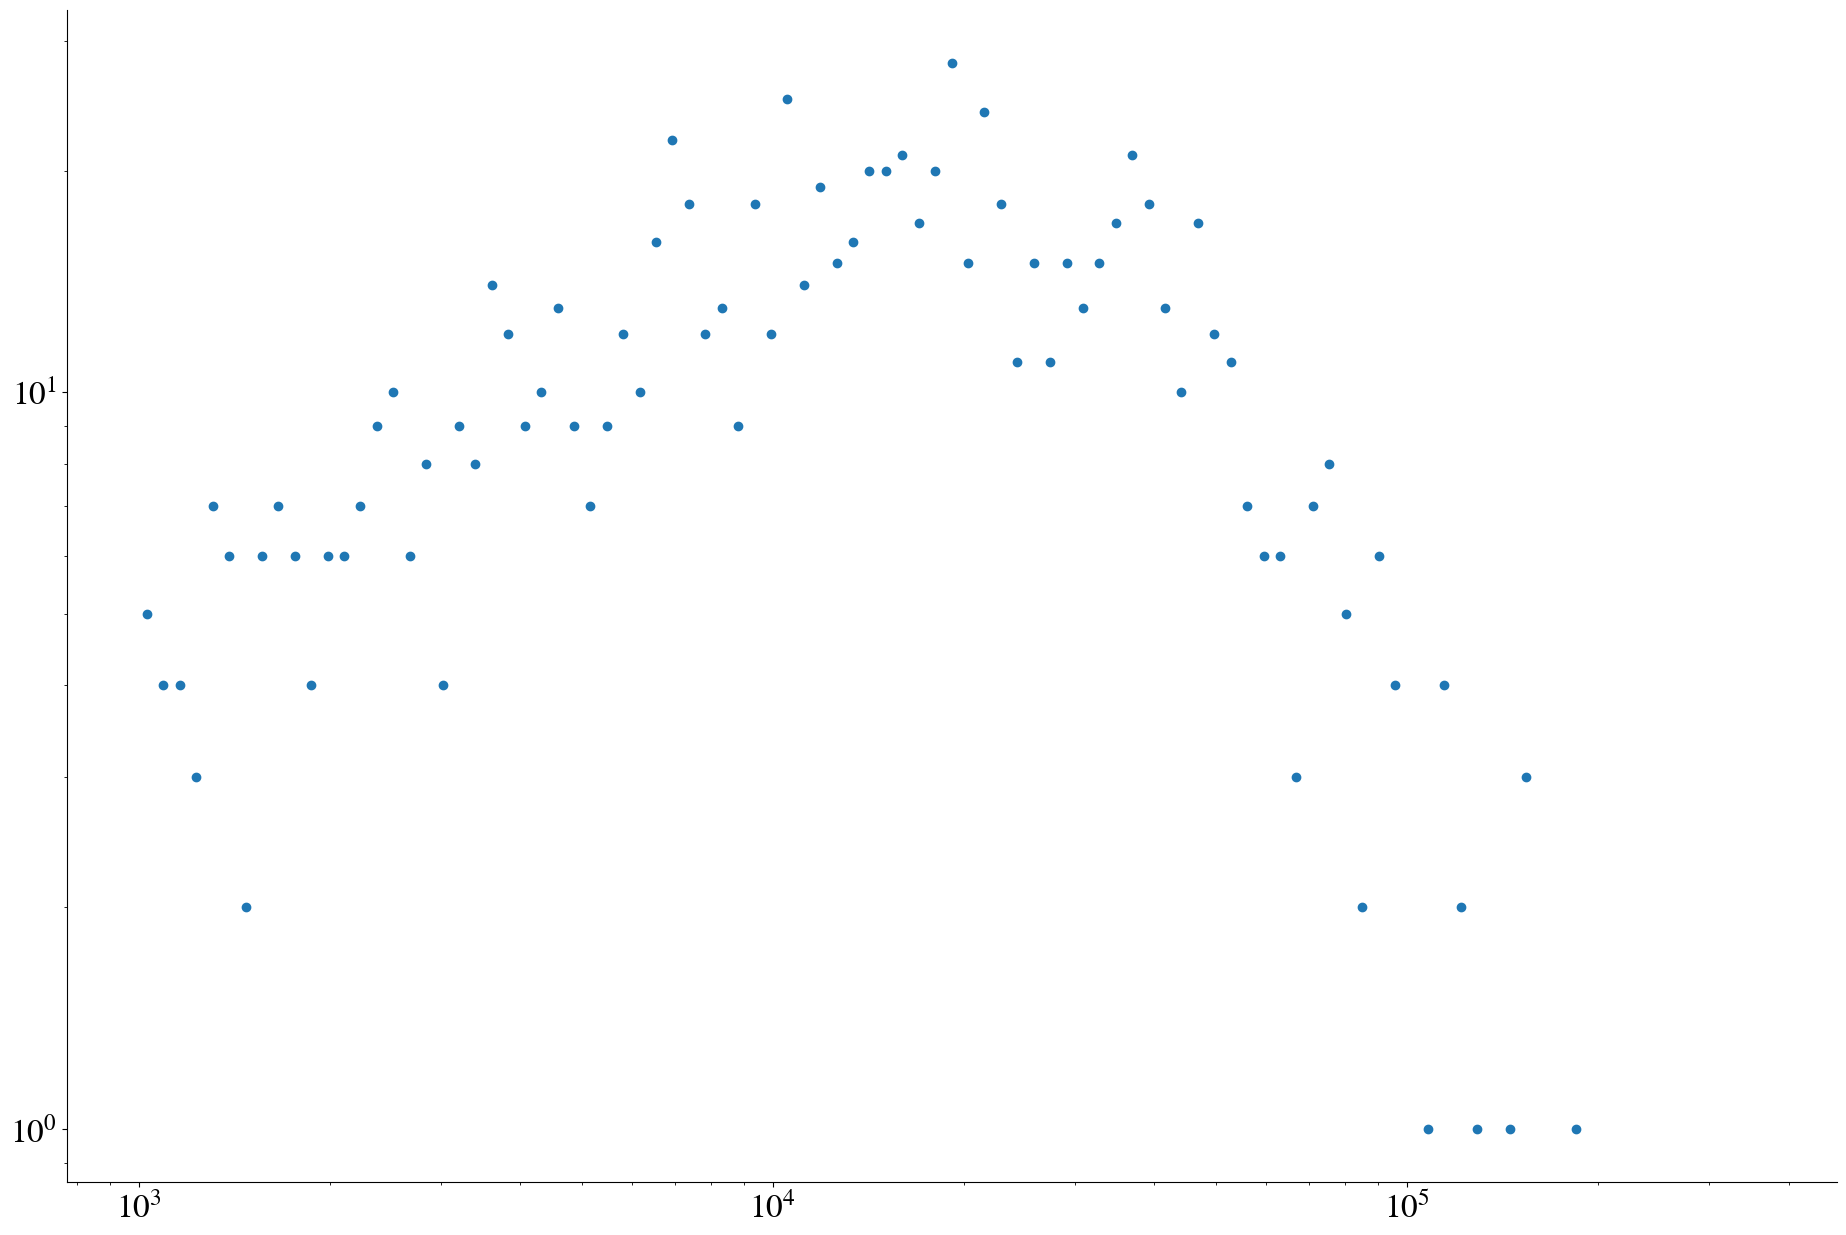

In [160]:
len_sequences = {}
len_sequences_to_sort = []
num_users = len(users)
print(num_users)
for ID, user in tqdm(users.items()):
    sequence = user["sequence_tracks"]
    sequence_labels = user["sequence_artists"]
    len_sequences[ID] = len(sequence)
    len_sequences_to_sort.append((len(sequence), ID))
len_sequences_sorted = sorted(len_sequences_to_sort)
for i in range(11):
    print(f'Excluding %d%% len is %d'%(i*10, len_sequences_sorted[int(i/10*(num_users-1))][0]))
vals, bin_edges = np.histogram(list(len_sequences.values()), bins = np.geomspace(min_len_sequence,2*max(list(len_sequences.values())), 100))
bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
plt.scatter(bin_centers, vals)
plt.loglog()

[]

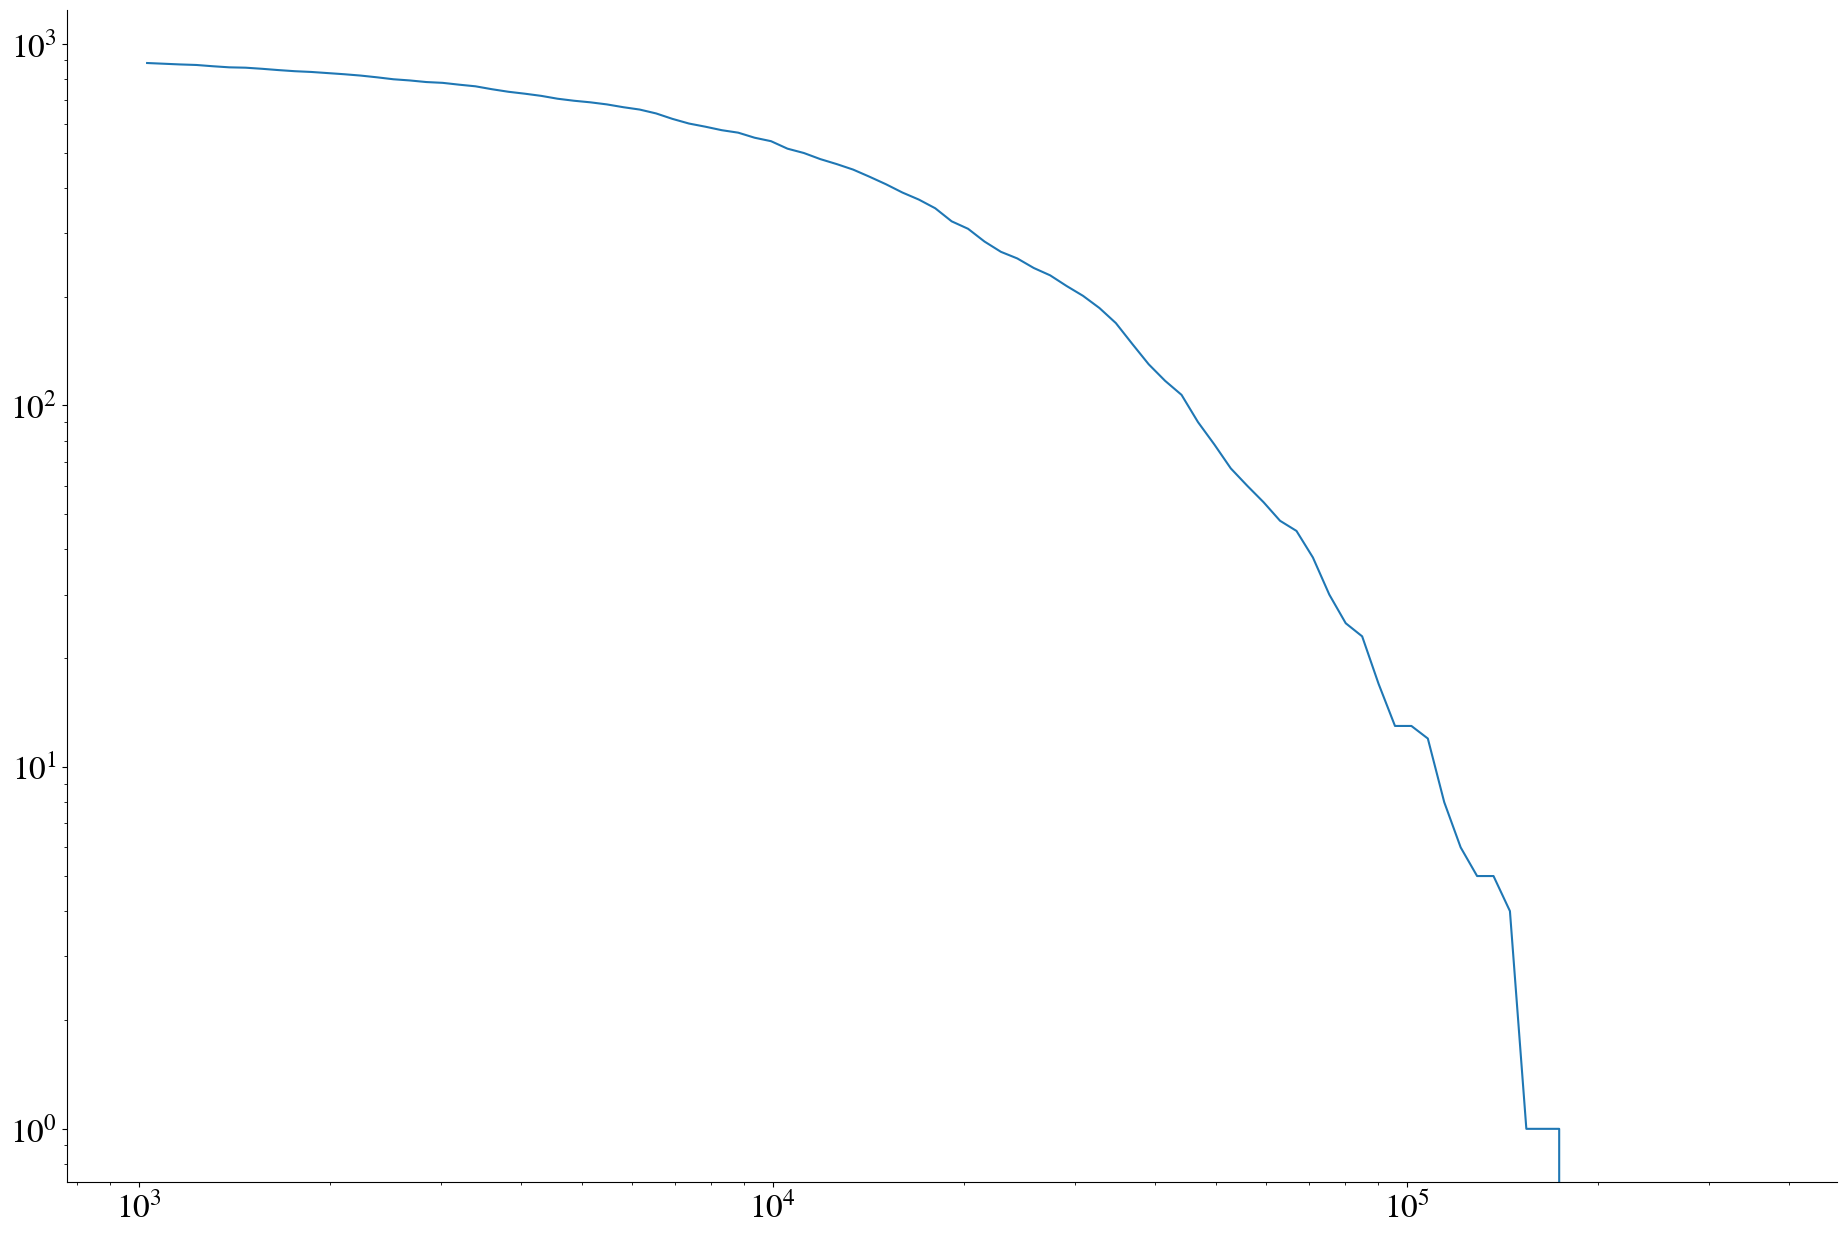

In [161]:
cum = 0
cum_vals = []
sum_vals = sum(vals)
for val in vals:
    cum += val
    cum_vals.append(sum_vals - cum)
plt.plot(bin_centers, cum_vals)
plt.loglog()

In [162]:
median_len_sequences = int(np.round(np.median(list(len_sequences.values()))))
print("Median len of the sequences is",median_len_sequences)

Median len of the sequences is 13985


In [ ]:
average_user = {
    'D':np.zeros(median_len_sequences,dtype=float), 
    'D2':np.zeros(median_len_sequences,dtype=float), 
    'D3':np.zeros(median_len_sequences,dtype=float), 
    'D4':np.zeros(median_len_sequences,dtype=float), 
}
count = 0
for userid in tqdm(users_list):
    save_all_file_path = f"./data/ocelma-dataset/lastfm-dataset-1K/individual_results/{userid}.pkl"
    with open(save_all_file_path, 'rb') as fp:
        user_result = pickle.load(fp)
    if len(user_result['D']) > median_len_sequences:
        count += 1
        average_user['D'] += user_result['D'][:median_len_sequences]
        average_user['D2'] += user_result['D2'][:median_len_sequences]
        average_user['D3'] += user_result['D3'][:median_len_sequences]
        average_user['D4'] += user_result['D4'][:median_len_sequences]
#     print(f"found {userid}")
average_user['D']  /= count
average_user['D2'] /= count
average_user['D3'] /= count
average_user['D4'] /= count
print(count)

In [164]:
D = average_user['D']
D2 = average_user['D2']
D3 = average_user['D3']
D4 = average_user['D4']
indices = np.arange(len(D))
save_light_file_path = os.path.join('./data/ocelma-dataset/lastfm-dataset-1K/', f"average_individual_results_light.pkl")
save_all_file_path = os.path.join('./data/ocelma-dataset/lastfm-dataset-1K/', f"average_individual_results.pkl")
average_results_light_lastfm = analyse_sequence(None, num_to_save=1000, find_novelties = False, 
                         calculate_entropies_original = False, calculate_entropies_labels = False,
                         D=D, D2=D2, D3=D3, D4=D4, sequence_labels = None,
                         save_all=True, save_all_file_path = save_all_file_path, 
                         save_light_file_path = save_light_file_path,
                         calculate_beta_loglogregr_indices = False,
                         use_D_as_D_indices = True, indices=indices,
                         do_prints = False, return_all = False)

In [165]:
average_user_artists = {
    'D':np.zeros(median_len_sequences,dtype=float), 
    'D2':np.zeros(median_len_sequences,dtype=float), 
    'D3':np.zeros(median_len_sequences,dtype=float), 
    'D4':np.zeros(median_len_sequences,dtype=float), 
}
count = 0
for userid in tqdm(users_list):
    save_all_file_path = f"./data/ocelma-dataset/lastfm-dataset-1K/individual_results_artists/{userid}.pkl"
    with open(save_all_file_path, 'rb') as fp:
        user_result = pickle.load(fp)
    if len(user_result['D']) > median_len_sequences:
        count += 1
        average_user_artists['D'] += user_result['D'][:median_len_sequences]
        average_user_artists['D2'] += user_result['D2'][:median_len_sequences]
        average_user_artists['D3'] += user_result['D3'][:median_len_sequences]
        average_user_artists['D4'] += user_result['D4'][:median_len_sequences]
average_user_artists['D']  /= count
average_user_artists['D2'] /= count
average_user_artists['D3'] /= count
average_user_artists['D4'] /= count
print(count)

  0%|          | 0/890 [00:00<?, ?it/s]

445


In [167]:
D = average_user_artists['D']
D2 = average_user_artists['D2']
D3 = average_user_artists['D3']
D4 = average_user_artists['D4']
indices = np.arange(len(D))
save_light_file_path = os.path.join('./data/ocelma-dataset/lastfm-dataset-1K/', f"average_individual_results_artists_light.pkl")
save_all_file_path = os.path.join('./data/ocelma-dataset/lastfm-dataset-1K/', f"average_individual_results_artists.pkl")
average_results_light_lastfm_artists = analyse_sequence(None, num_to_save=1000, find_novelties = False, 
                         calculate_entropies_original = False, calculate_entropies_labels = False,
                         D=D, D2=D2, D3=D3, D4=D4, sequence_labels = None,
                         save_all=True, save_all_file_path = save_all_file_path, 
                         save_light_file_path = save_light_file_path,
                         calculate_beta_loglogregr_indices = False,
                         use_D_as_D_indices = True, indices=indices,
                         do_prints = False, return_all = False)

# Gutenberg

Only consider English books using https://github.com/pgcorpus/gutenberg

In [7]:
data_folder = './data/gutenberg/data/'
analysis_folder = './data/gutenberg/analysis/'
os.makedirs(analysis_folder, exist_ok = True)
text_folder = './data/gutenberg/data/text/'

## Data collection

In [10]:
min_len_sequence = 1000

In [11]:
paths = sorted(find_pattern('*.txt', text_folder))
paths[:10]

['./gutenberg/data/text/PG10000_text.txt',
 './gutenberg/data/text/PG10007_text.txt',
 './gutenberg/data/text/PG1000_text.txt',
 './gutenberg/data/text/PG10012_text.txt',
 './gutenberg/data/text/PG1001_text.txt',
 './gutenberg/data/text/PG1002_text.txt',
 './gutenberg/data/text/PG10031_text.txt',
 './gutenberg/data/text/PG10039_text.txt',
 './gutenberg/data/text/PG1003_text.txt',
 './gutenberg/data/text/PG1004_text.txt']

In [12]:
IDs = [path.split('/')[-1].split('_')[0] for path in paths]
IDs[:10]

['PG10000',
 'PG10007',
 'PG1000',
 'PG10012',
 'PG1001',
 'PG1002',
 'PG10031',
 'PG10039',
 'PG1003',
 'PG1004']

In [ ]:
try:
    raise KeyError
    print('Trying to load word2index and word2stem mapping...')
    with gzip.open(os.path.join(analysis_folder, 'word2index.pkl.gz'), 'rb') as fp:
        word2index = joblib.load(fp)
    with gzip.open(os.path.join(analysis_folder, 'word2stem.pkl.gz'), 'rb') as fp:
        word2stem = joblib.load(fp)
    print('Loaded word2index and word2stem mapping')
except:
    print('Computing word2index and word2stem mapping...')
    all_books = {}
    word2index = {}
    max_index = 0
    word2stem = {}
    stem2index = {}
    max_stem_index = 0
    english_IDs = []
    for path in tqdm(paths):
        ID = path.split('/')[-1].split('_')[0]
        with open(path, 'r') as fp:
            text = fp.read()
        language_prediction = cld3.get_language(text) # technically now they are all english texts, so no need for this
#         if language_prediction.probability > 0.5: # probability > 0.99: # is_reliable == True:
        language = language_prediction.language # This gives a iso639 code
        if language != 'en':
            continue
        language = languages.get(alpha2=language).name # get the full name of the language from its iso639 code
#         else:
#             print(text,language_prediction, language)
#             break
        words = lemmatize(text)
        if len(words) < min_len_sequence:
            continue
        sequence_words = []
        sequence_stems = []
        snow_stemmer = SnowballStemmer(language=language.lower())
        for word in words:
            if word not in word2index:
                word2index[word] = max_index
                max_index += 1
                stem = snow_stemmer.stem(word)
                word2stem[word] = stem
                if stem not in stem2index:
                    stem2index[stem] = max_stem_index
                    max_stem_index += 1
            sequence_words.append(word2index[word])
            sequence_stems.append(stem2index[word2stem[word]])
        all_books[ID] = {'ID':ID, 'sequence_words':sequence_words, 'sequence_stems':sequence_stems}
        english_IDs.append(ID)
    print(f'Found {len(english_IDs)} english books with more than 1000 words out of {len(IDs)}')
    # Dump
    with gzip.open(os.path.join(analysis_folder, 'word2index.pkl.gz'), 'wb') as fp:
        joblib.dump(word2index,fp)
    with gzip.open(os.path.join(analysis_folder, 'word2stem.pkl.gz'), 'wb') as fp:
        joblib.dump(word2stem,fp)
    with gzip.open(os.path.join(analysis_folder, 'stem2index.pkl.gz'), 'wb') as fp:
        joblib.dump(stem2index,fp)
    with gzip.open(os.path.join(analysis_folder, 'all_books_preprocessed.pkl.gz'), 'wb') as fp:
        joblib.dump(all_books,fp)
    print('Dumped')

Computing word2index and word2stem mapping...


  0%|          | 0/25079 [00:00<?, ?it/s]

Found 19637 english books with more than 1000 words out of 25079


## Individual analysis

In [8]:
with gzip.open(os.path.join(analysis_folder, "all_books_preprocessed.pkl.gz"), "rb") as fp:
    all_books = joblib.load(fp)

In [ ]:
results_light_individual_gutenberg = {} 
for ID, book in tqdm(all_books.items()):
    sequence = book["sequence_words"]
    sequence_labels = book["sequence_stems"]
    save_light_file_path = os.path.join(analysis_folder, f"individual_results_light/{ID}_light.pkl")
    save_all_file_path = f"/data/scratch/ahw701/pairs/gutenberg/analysis/individual_results/{ID}.pkl"
    results_light_individual_gutenberg[ID] = analyse_sequence(sequence, num_to_save=1000, find_novelties = True, 
                         calculate_entropies_original = False, calculate_entropies_labels = True,
                         D=None, D2=None, D3=None, D4=None, sequence_labels = sequence_labels,
                         save_all=True, save_all_file_path = save_all_file_path, 
                         save_light_file_path = save_light_file_path,
                         calculate_beta_loglogregr_indices = False,
                         do_prints = False, return_all = False)

  0%|          | 0/19637 [00:00<?, ?it/s]

In [ ]:
with gzip.open(os.path.join(analysis_folder, "results_light_texts.pkl.gz"), "wb") as fp:
    joblib.dump(results_light_individual_gutenberg, fp)

In [ ]:
results_light_individual_gutenberg_stems = {} 
for ID, book in tqdm(all_books.items()):
    sequence = book["sequence_stems"]
    sequence_labels = book["sequence_stems"]
    save_light_file_path = os.path.join(analysis_folder, f"individual_results_stems_light/{ID}_light.pkl")
    save_all_file_path = f"/data/scratch/ahw701/pairs/gutenberg/analysis/individual_results_stems/{ID}.pkl"
    results_light_individual_gutenberg_stems[ID] = analyse_sequence(sequence, num_to_save=1000, find_novelties = True, 
                         calculate_entropies_original = False, calculate_entropies_labels = True,
                         D=None, D2=None, D3=None, D4=None, sequence_labels = sequence_labels,
                         save_all=True, save_all_file_path = save_all_file_path, 
                         save_light_file_path = save_light_file_path,
                         calculate_beta_loglogregr_indices = False,
                         do_prints = False, return_all = False)

In [ ]:
with gzip.open(os.path.join(analysis_folder, "results_light_stems.pkl.gz"), "wb") as fp:
    joblib.dump(results_light_individual_gutenberg_stems, fp)

## Average individual analysis

In [ ]:
with gzip.open(os.path.join(analysis_folder, "all_books_preprocessed.pkl.gz"), "rb") as fp:
    all_books = joblib.load(fp)

  0%|          | 0/19637 [00:00<?, ?it/s]

Excluding 0% len is 1003
Excluding 10% len is 7584
Excluding 20% len is 16262
Excluding 30% len is 26327
Excluding 40% len is 39107
Excluding 50% len is 50726
Excluding 60% len is 62836
Excluding 70% len is 78279
Excluding 80% len is 100108
Excluding 90% len is 142297
Excluding 100% len is 2124926


[]

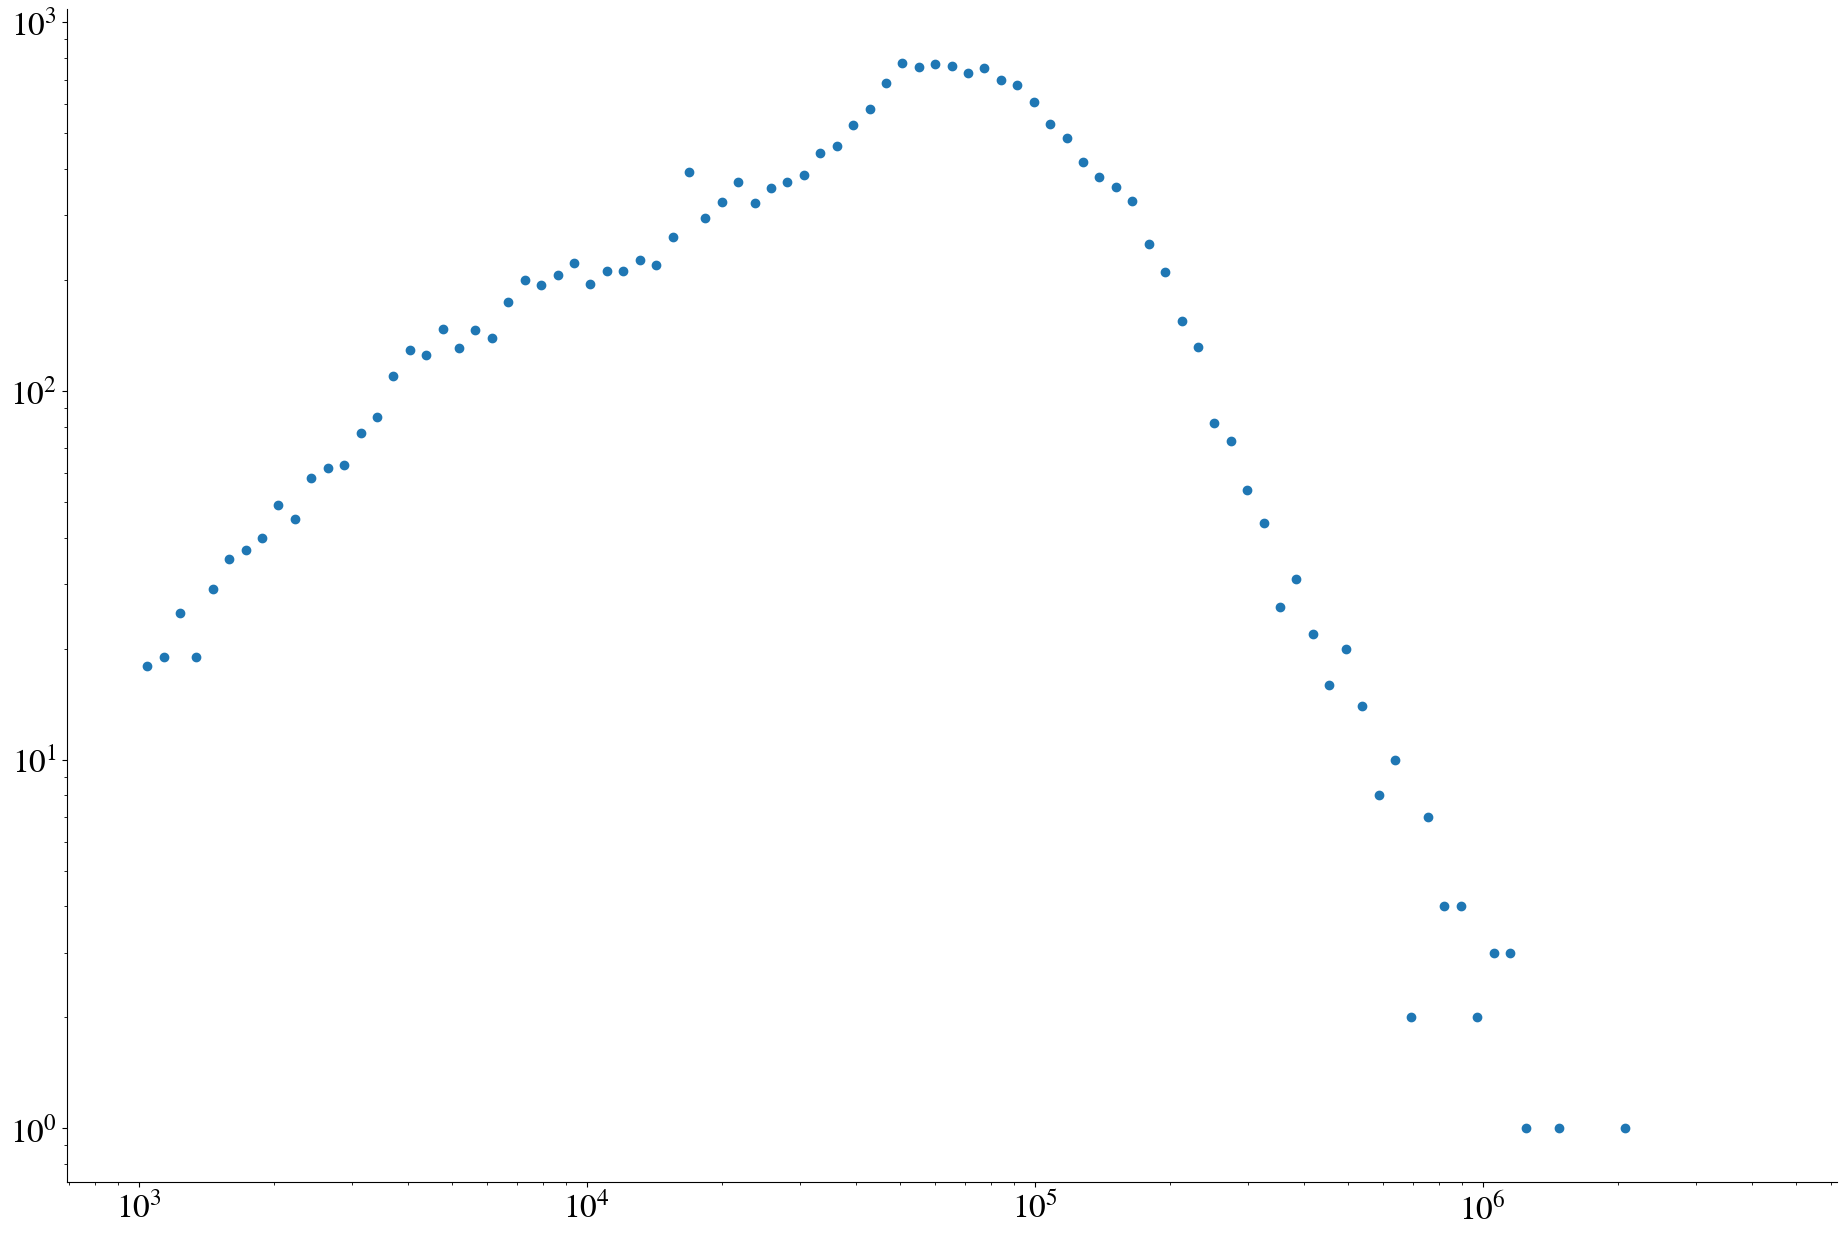

In [123]:
len_sequences = {}
len_sequences_to_sort = []
num_books = len(all_books)
for ID, book in tqdm(all_books.items()):
    sequence = book["sequence_words"]
    sequence_labels = book["sequence_stems"]
    len_sequences[ID] = len(sequence)
    len_sequences_to_sort.append((len(sequence), ID))
len_sequences_sorted = sorted(len_sequences_to_sort)
for i in range(11):
    print(f'Excluding %d%% len is %d'%(i*10, len_sequences_sorted[int(i/10*(num_books-1))][0]))
vals, bin_edges = np.histogram(list(len_sequences.values()), bins = np.geomspace(min_len_sequence,2*max(list(len_sequences.values())), 100))
bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
plt.scatter(bin_centers, vals)
plt.loglog()

[]

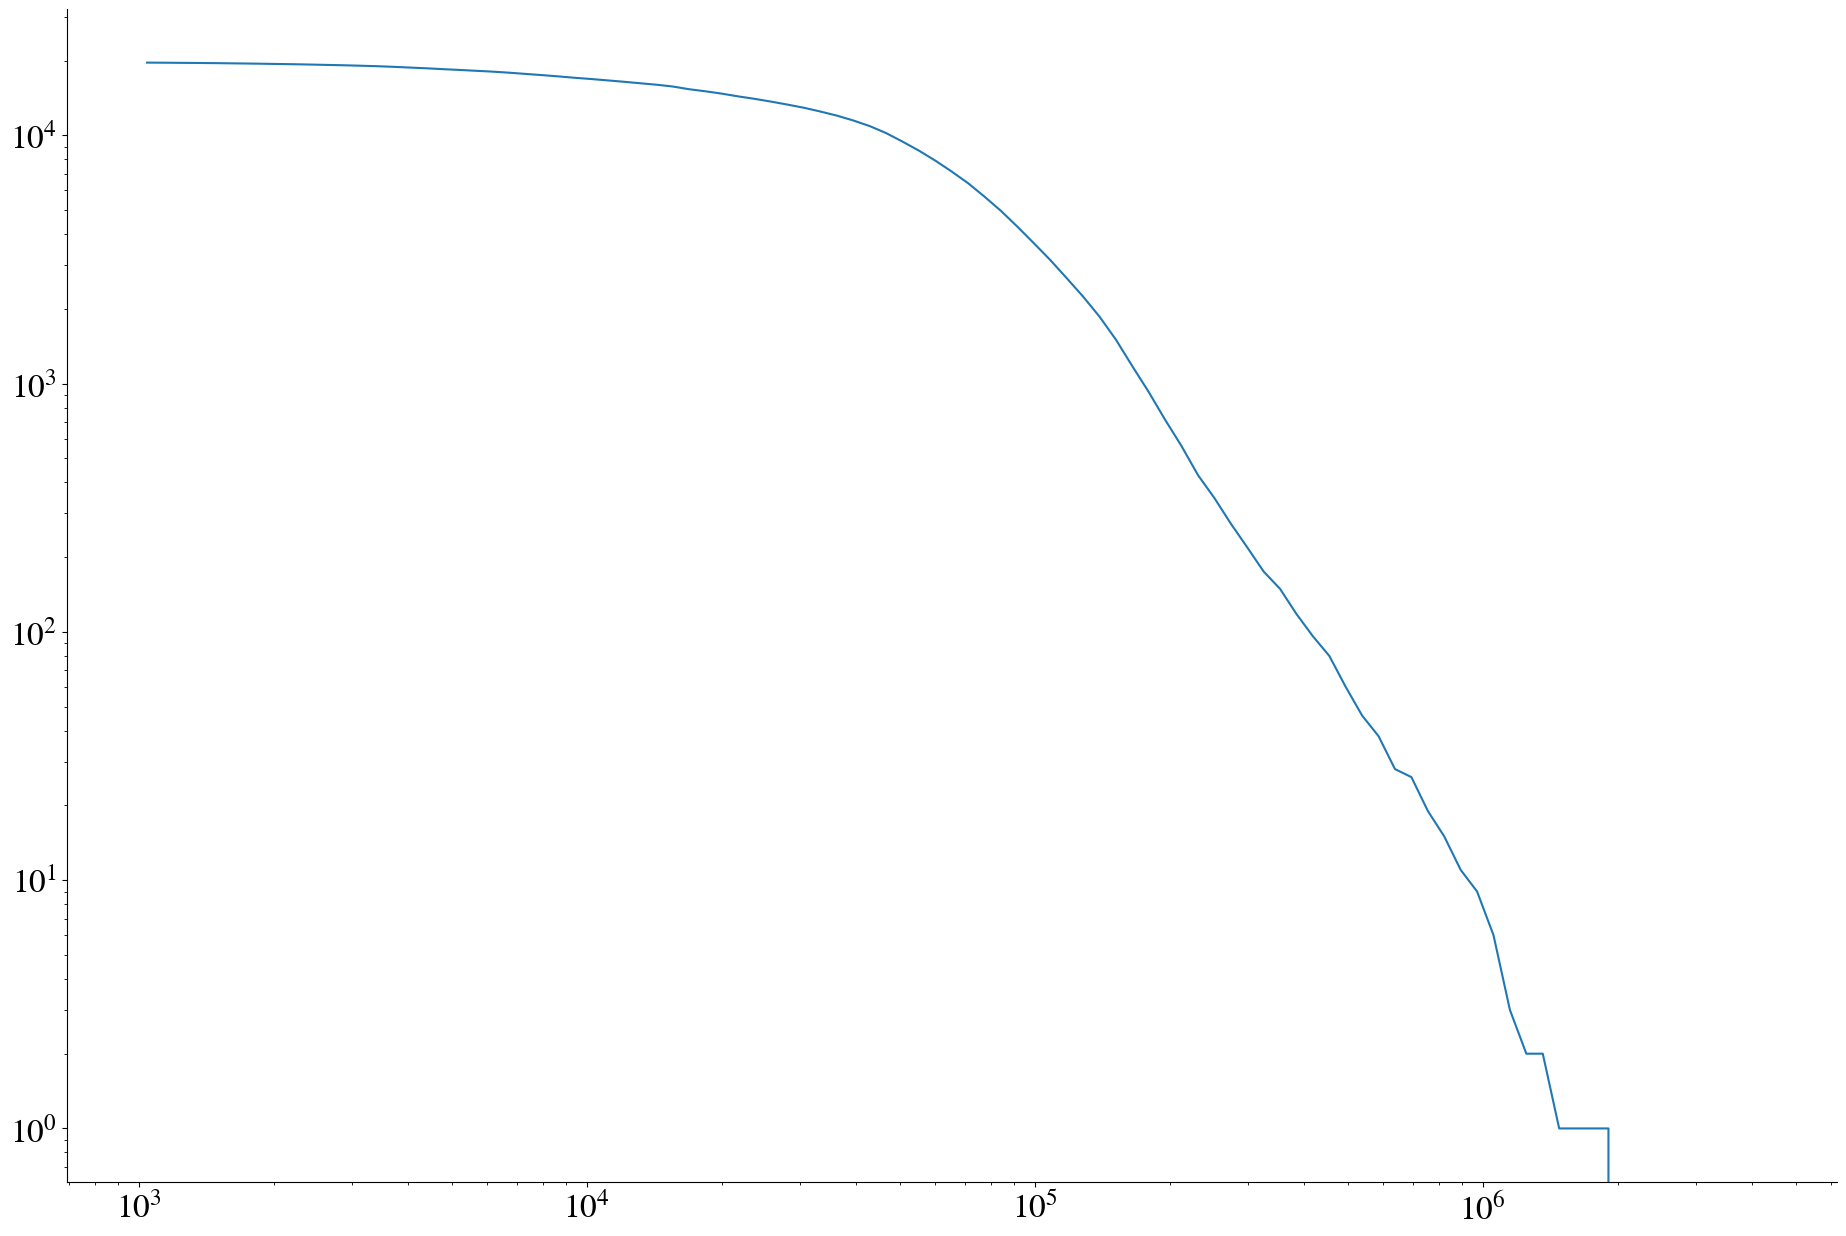

In [124]:
cum = 0
cum_vals = []
sum_vals = sum(vals)
for val in vals:
    cum += val
    cum_vals.append(sum_vals - cum)
plt.plot(bin_centers, cum_vals)
plt.loglog()

In [125]:
median_len_sequences = int(np.round(np.median(list(len_sequences.values()))))
print("Median len of the sequences is",median_len_sequences)

Median len of the sequences is 50726


In [126]:
average_book = {
    'D':np.zeros(median_len_sequences,dtype=float), 
    'D2':np.zeros(median_len_sequences,dtype=float), 
    'D3':np.zeros(median_len_sequences,dtype=float), 
    'D4':np.zeros(median_len_sequences,dtype=float), 
}
count = 0
for ID, book in tqdm(all_books.items()):
    save_all_file_path = f"/data/scratch/ahw701/pairs/gutenberg/analysis/individual_results/{ID}.pkl"
    with open(save_all_file_path, 'rb') as fp:
        book_result = pickle.load(fp)
    if len(book_result['D']) > median_len_sequences:
        count += 1
        average_book['D'] += book_result['D'][:median_len_sequences]
        average_book['D2'] += book_result['D2'][:median_len_sequences]
        average_book['D3'] += book_result['D3'][:median_len_sequences]
        average_book['D4'] += book_result['D4'][:median_len_sequences]
average_book['D']  /= count
average_book['D2'] /= count
average_book['D3'] /= count
average_book['D4'] /= count
print(count)

  0%|          | 0/19637 [00:00<?, ?it/s]

9818


In [127]:
D = average_book['D']
D2 = average_book['D2']
D3 = average_book['D3']
D4 = average_book['D4']
indices = np.arange(len(D))
save_light_file_path = os.path.join(analysis_folder, f"average_individual_results_light.pkl")
save_all_file_path = os.path.join(analysis_folder, f"average_individual_results.pkl")
average_results_light_gutenberg = analyse_sequence(None, num_to_save=1000, find_novelties = False, 
                         calculate_entropies_original = False, calculate_entropies_labels = False,
                         D=D, D2=D2, D3=D3, D4=D4, sequence_labels = None,
                         save_all=True, save_all_file_path = save_all_file_path, 
                         save_light_file_path = save_light_file_path,
                         calculate_beta_loglogregr_indices = False,
                         use_D_as_D_indices = True, indices=indices,
                         do_prints = False, return_all = False)

In [128]:
average_book_stems = {
    'D':np.zeros(median_len_sequences,dtype=float), 
    'D2':np.zeros(median_len_sequences,dtype=float), 
    'D3':np.zeros(median_len_sequences,dtype=float), 
    'D4':np.zeros(median_len_sequences,dtype=float), 
}
count = 0
for ID, book in tqdm(all_books.items()):
    save_all_file_path = f"/data/scratch/ahw701/pairs/gutenberg/analysis/individual_results_stems/{ID}.pkl"
    with open(save_all_file_path, 'rb') as fp:
        book_result = pickle.load(fp)
    if len(book_result['D']) > median_len_sequences:
        count += 1
        average_book_stems['D'] += book_result['D'][:median_len_sequences]
        average_book_stems['D2'] += book_result['D2'][:median_len_sequences]
        average_book_stems['D3'] += book_result['D3'][:median_len_sequences]
        average_book_stems['D4'] += book_result['D4'][:median_len_sequences]
average_book_stems['D']  /= count
average_book_stems['D2'] /= count
average_book_stems['D3'] /= count
average_book_stems['D4'] /= count
print(count)

  0%|          | 0/19637 [00:00<?, ?it/s]

9818


In [129]:
D = average_book_stems['D']
D2 = average_book_stems['D2']
D3 = average_book_stems['D3']
D4 = average_book_stems['D4']
save_light_file_path = os.path.join(analysis_folder, f"average_individual_results_stems_light.pkl")
save_all_file_path = os.path.join(analysis_folder, f"average_individual_results_stems.pkl")
average_results_light_gutenberg_stems = analyse_sequence(None, num_to_save=1000, find_novelties = False, 
                         calculate_entropies_original = False, calculate_entropies_labels = False,
                         D=D, D2=D2, D3=D3, D4=D4, sequence_labels = None,
                         save_all=True, save_all_file_path = save_all_file_path, 
                         save_light_file_path = save_light_file_path,
                         calculate_beta_loglogregr_indices = False,
                         use_D_as_D_indices = True, indices=indices,
                         do_prints = False, return_all = False)

# Semantic Scholar dataset

Created in ./semanticscholar/dataset_creation.ipynb

In [9]:
corpus_version = '2022-01-01'
data_folder = os.path.join('./data/semanticscholar/data/', corpus_version) # where you save the data

In [10]:
with open(os.path.join(data_folder,'all_fieldsOfStudy.tsv'), 'r', newline='\n') as fp:
    tsv_output = csv.reader(fp, delimiter='\n')
    all_fieldsOfStudy = [] 
    for _ in tsv_output:
        all_fieldsOfStudy.append(_[0])

In [11]:
all_fieldsOfStudy

['Art',
 'Biology',
 'Business',
 'Chemistry',
 'Computer Science',
 'Economics',
 'Engineering',
 'Environmental Science',
 'Geography',
 'Geology',
 'History',
 'Materials Science',
 'Mathematics',
 'Medicine',
 'Philosophy',
 'Physics',
 'Political Science',
 'Psychology',
 'Sociology']

## By field of study and journal

In [25]:
data_folder = os.path.join('./data/gutenberg/data_processed')
for book_id, tmp_dict in tqdm(all_books.items()):
    with open(os.path.join(data_folder, 'sequences_words', f'{book_id}.pkl'), 'wb') as fp:
        joblib.dump(tmp_dict['sequence_words'], fp)
    with open(os.path.join(data_folder, 'sequences_stems', f'{book_id}.pkl'), 'wb') as fp:
        joblib.dump(tmp_dict['sequence_stems'], fp)

  0%|          | 0/19637 [00:00<?, ?it/s]

In [22]:
all_books['PG10000']['sequence_words'][:10]

[0, 1, 2, 3, 0, 4, 5, 1, 2, 1]

In [12]:
analysis_folder = os.path.join('./data/semanticscholar/analysis/', corpus_version)
os.makedirs(analysis_folder,exist_ok = True)

### Individual analysis

In [ ]:
all_fieldsOfStudy = ['Computer Science']

In [ ]:
results_light_individual_journals_fieldsOfStudy = {}
num_journals = 1000
for fieldOfStudy in tqdm(all_fieldsOfStudy):
    fieldsOfStudy_folder = os.path.join(data_folder,'journals_fieldsOfStudy',fieldOfStudy)
    journals_filepaths = sorted(find_pattern('*.tsv', fieldsOfStudy_folder))
    if len(journals_filepaths) != num_journals:
        print(f'Error! Found {len(journals_filepaths)} journals for {fieldOfStudy} instead of {num_journals}')
        break
        
    results_light_individual_journals_fieldsOfStudy[fieldOfStudy] = {}
    for path in tqdm(journals_filepaths):
        sequence = [] 
        with open(path, 'r', newline='\n') as fp:
            tsv_output = csv.reader(fp, delimiter='\n')
            for _ in tsv_output:
                sequence.append(int(_[0]))
        sequence_labels = sequence.copy()
        file_name = path[-path[::-1].index('/'):path.index('.tsv')]
        save_light_file_path = os.path.join(analysis_folder, 'journals_fieldsOfStudy',fieldOfStudy,file_name + '.pkl')
        save_all_file_path = os.path.join('/data/scratch/ahw701/pairs/semanticscholar', 'journals_fieldsOfStudy',fieldOfStudy,file_name + '.pkl')
        results_light_individual_journals_fieldsOfStudy[fieldOfStudy][file_name] = analyse_sequence(sequence, num_to_save=1000, find_novelties = True, 
                         calculate_entropies_original = False, calculate_entropies_labels = True,
                         D=None, D2=None, D3=None, D4=None, sequence_labels = sequence_labels,
                         save_all=True, save_all_file_path = save_all_file_path, 
                         save_light_file_path = save_light_file_path,
                         calculate_beta_loglogregr_indices = False,
                         do_prints = False, return_all = False)

In [ ]:
with gzip.open(os.path.join(analysis_folder, 'journals_fieldsOfStudy', 'results_light_texts.pkl.gz'), 'wb') as fp:
    joblib.dump(results_light_individual_journals_fieldsOfStudy, fp)

In [10]:
results_light_individual_journals_fieldsOfStudy_stems = {}
num_journals = 1000
for fieldOfStudy in tqdm(all_fieldsOfStudy):
    fieldsOfStudy_folder = os.path.join(data_folder,'journals_fieldsOfStudy_stems',fieldOfStudy)
    journals_filepaths = sorted(find_pattern('*.tsv', fieldsOfStudy_folder))
    if len(journals_filepaths) != num_journals:
        print(f'Error! Found {len(journals_filepaths)} journals for {fieldOfStudy} instead of {num_journals}')
        break
        
    results_light_individual_journals_fieldsOfStudy_stems[fieldOfStudy] = {}
    for path in tqdm(journals_filepaths):
        sequence = [] 
        with open(path, 'r', newline='\n') as fp:
            tsv_output = csv.reader(fp, delimiter='\n')
            for _ in tsv_output:
                sequence.append(int(_[0]))
        sequence_labels = sequence.copy()
        file_name = path[-path[::-1].index('/'):path.index('.tsv')]
        save_light_file_path = os.path.join(analysis_folder, 'journals_fieldsOfStudy_stems',fieldOfStudy,file_name + '.pkl')
        save_all_file_path = os.path.join('/data/scratch/ahw701/pairs/semanticscholar', 'journals_fieldsOfStudy_stems',fieldOfStudy,file_name + '.pkl')
        results_light_individual_journals_fieldsOfStudy_stems[fieldOfStudy][file_name] = analyse_sequence(sequence, num_to_save=1000, find_novelties = True, 
                         calculate_entropies_original = False, calculate_entropies_labels = True,
                         D=None, D2=None, D3=None, D4=None, sequence_labels = sequence_labels,
                         save_all=True, save_all_file_path = save_all_file_path, 
                         save_light_file_path = save_light_file_path,
                         calculate_beta_loglogregr_indices = False,
                         do_prints = False, return_all = False)

  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

/data/home/ahw701/env_enrico/envs/gt/lib/python3.9/site-packages/numba/core/ir_utils.py:2119: NumbaPendingDeprecationWarning: 
Encountered the use of a type that is scheduled for deprecation: type 'reflected list' found for argument 'seq' of function 'entropyCalc'.

For more information visit https://numba.pydata.org/numba-doc/latest/reference/deprecation.html#deprecation-of-reflection-for-list-and-set-types

File "utils/entropy.py", line 6:
@njit
def entropyCalc(seq, labels_freq_keys, labels_freq_values):
^

  warnings.warn(NumbaPendingDeprecationWarning(msg, loc=loc))


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



  0%|          | 0/1000 [00:00<?, ?it/s]

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



  0%|          | 0/1000 [00:00<?, ?it/s]

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



In [13]:
with gzip.open(os.path.join(analysis_folder, 'journals_fieldsOfStudy_stems', 'results_light_stems.pkl.gz'), 'wb') as fp:
    joblib.dump(results_light_individual_journals_fieldsOfStudy_stems, fp)

In [ ]:
with gzip.open(os.path.join(analysis_folder, 'journals_fieldsOfStudy', 'results_light_texts.pkl.gz'), 'rb') as fp:
    results_light_individual_journals_fieldsOfStudy = joblib.load(fp)

### Average individual analysis

In [153]:
analysis_folder = os.path.join('./data/semanticscholar/analysis/', corpus_version)
os.makedirs(analysis_folder,exist_ok = True)

This is done across fields of study

  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

[]

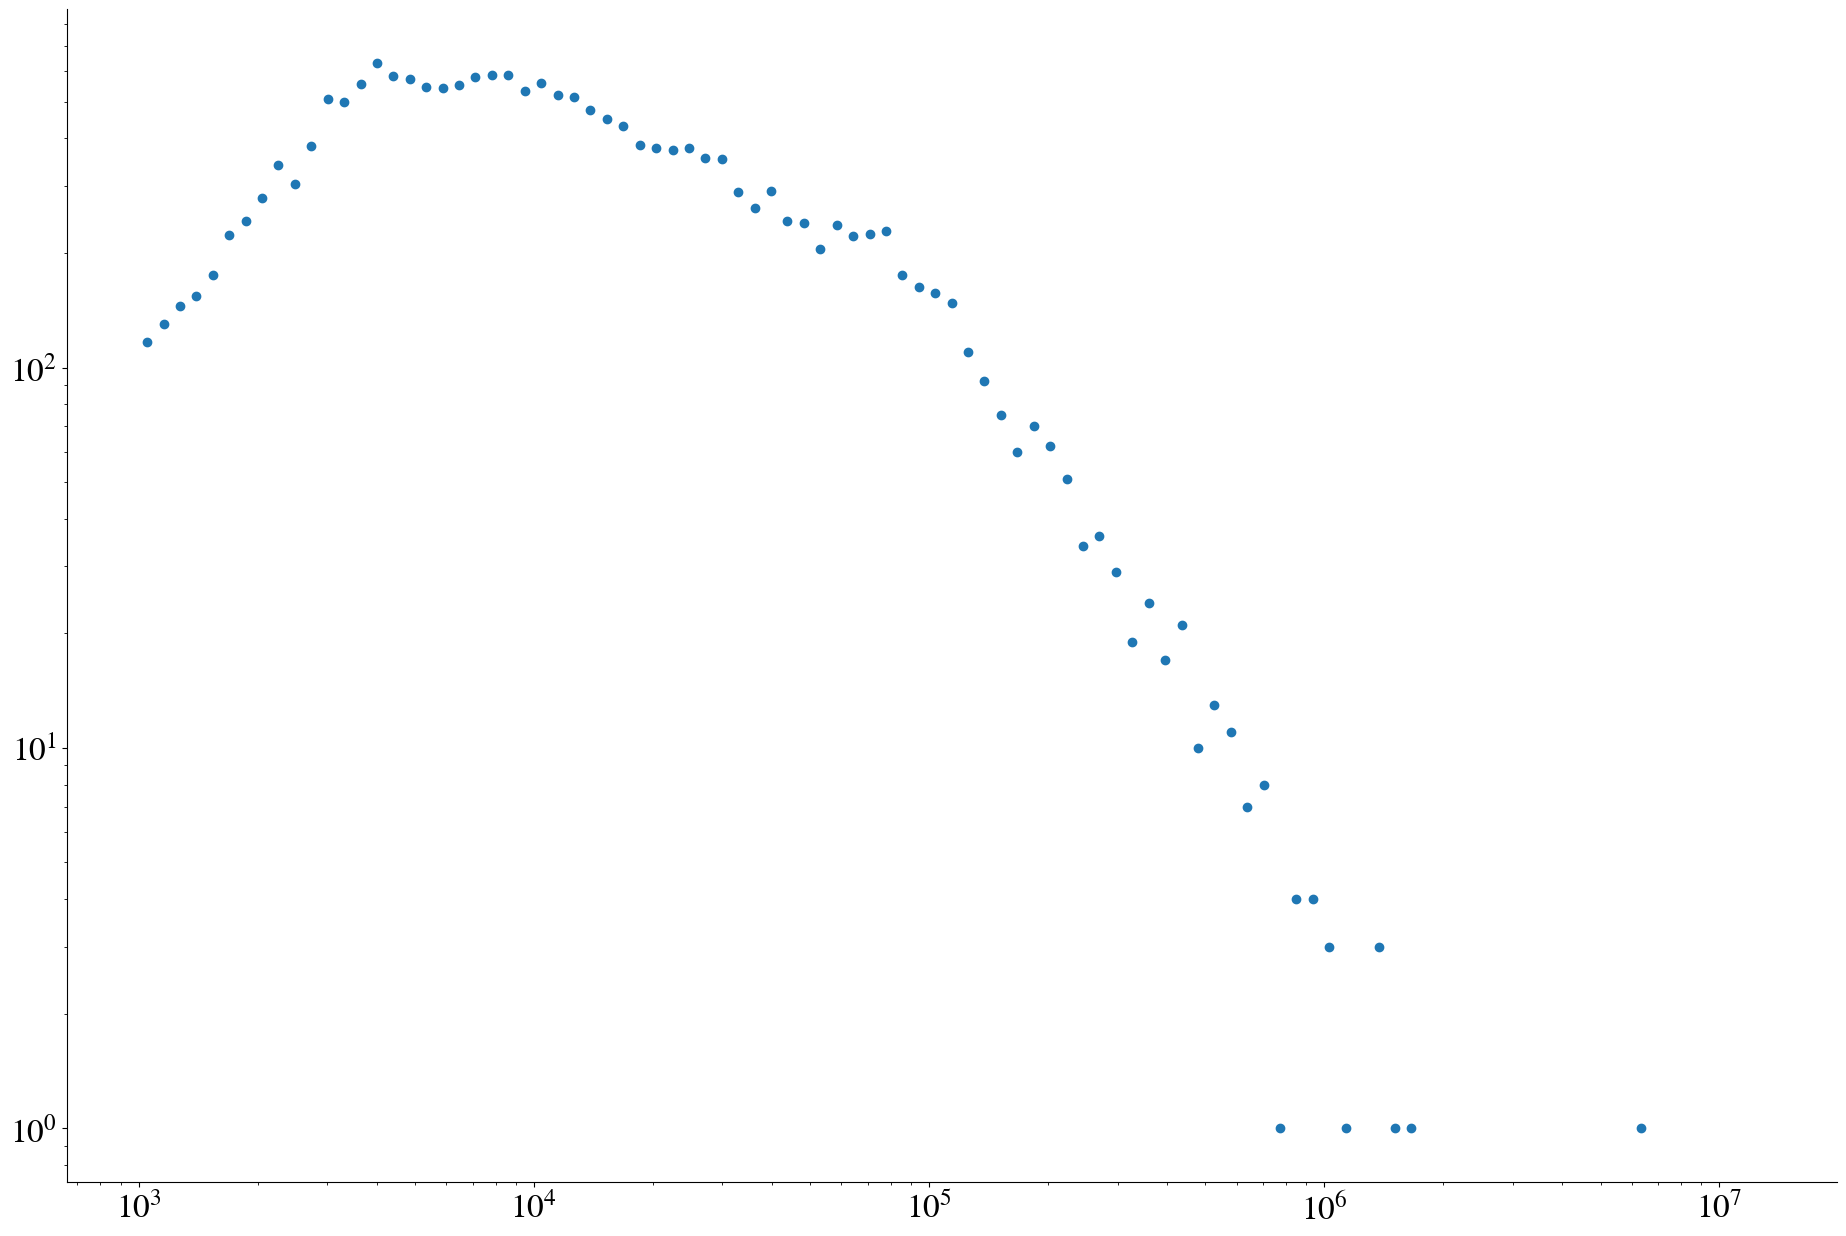

In [145]:
len_sequences = []
for fieldOfStudy in tqdm(all_fieldsOfStudy):
    fieldsOfStudy_folder = os.path.join(data_folder,'journals_fieldsOfStudy',fieldOfStudy)
    journals_filepaths = sorted(find_pattern('*.tsv', fieldsOfStudy_folder))
    if len(journals_filepaths) != num_journals:
        print(f'Error! Found {len(journals_filepaths)} journals for {fieldOfStudy} instead of {num_journals}')
        break
    for path in tqdm(journals_filepaths):
        file_name = path[-path[::-1].index('/'):path.index('.tsv')]
        save_all_file_path = os.path.join('/data/scratch/ahw701/pairs/semanticscholar', 'journals_fieldsOfStudy',fieldOfStudy,file_name + '.pkl')
        with open(save_all_file_path, 'rb') as fp:
            result = pickle.load(fp)
        sequence = result["sequence"]
        sequence_labels = result["sequence_labels"]
        len_sequences.append(len(sequence))
vals, bin_edges = np.histogram(list(len_sequences), bins = np.geomspace(min_len_sequence,2*max(list(len_sequences)), 100))
bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
plt.scatter(bin_centers, vals)
plt.loglog()

In [146]:
median_len_sequences = int(np.round(np.median(list(len_sequences))))
print("Median len of the sequences is",median_len_sequences)

Median len of the sequences is 9114


In [147]:
average_journal = {
    'D':np.zeros(median_len_sequences,dtype=float), 
    'D2':np.zeros(median_len_sequences,dtype=float), 
    'D3':np.zeros(median_len_sequences,dtype=float), 
    'D4':np.zeros(median_len_sequences,dtype=float), 
}
count = 0
for fieldOfStudy in tqdm(all_fieldsOfStudy):
    fieldsOfStudy_folder = os.path.join(data_folder,'journals_fieldsOfStudy',fieldOfStudy)
    journals_filepaths = sorted(find_pattern('*.tsv', fieldsOfStudy_folder))
    if len(journals_filepaths) != num_journals:
        print(f'Error! Found {len(journals_filepaths)} journals for {fieldOfStudy} instead of {num_journals}')
        break
    for path in tqdm(journals_filepaths):
        file_name = path[-path[::-1].index('/'):path.index('.tsv')]
        save_all_file_path = os.path.join('/data/scratch/ahw701/pairs/semanticscholar', 'journals_fieldsOfStudy',fieldOfStudy,file_name + '.pkl')
        with open(save_all_file_path, 'rb') as fp:
            result = pickle.load(fp)
        if len(result['D']) > median_len_sequences:
            count += 1
            average_journal['D'] += result['D'][:median_len_sequences]
            average_journal['D2'] += result['D2'][:median_len_sequences]
            average_journal['D3'] += result['D3'][:median_len_sequences]
            average_journal['D4'] += result['D4'][:median_len_sequences]
average_journal['D']  /= count
average_journal['D2'] /= count
average_journal['D3'] /= count
average_journal['D4'] /= count
print(count)

  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

9500


In [154]:
analysis_folder

'./semanticscholar/analysis/2022-01-01'

In [148]:
D = average_journal['D']
D2 = average_journal['D2']
D3 = average_journal['D3']
D4 = average_journal['D4']
indices = np.arange(len(D))
save_light_file_path = os.path.join(analysis_folder, 'average_individual_results_light_journals_fieldsOfStudy.pkl')
save_all_file_path = os.path.join(analysis_folder, f"average_individual_results_journals_fieldsOfStudy.pkl")
average_results_light_gutenberg = analyse_sequence(None, num_to_save=1000, find_novelties = False, 
                         calculate_entropies_original = False, calculate_entropies_labels = False,
                         D=D, D2=D2, D3=D3, D4=D4, sequence_labels = None,
                         save_all=True, save_all_file_path = save_all_file_path, 
                         save_light_file_path = save_light_file_path,
                         calculate_beta_loglogregr_indices = False,
                         use_D_as_D_indices = True, indices=indices,
                         do_prints = False, return_all = False)

In [155]:
average_journal_stems = {
    'D':np.zeros(median_len_sequences,dtype=float), 
    'D2':np.zeros(median_len_sequences,dtype=float), 
    'D3':np.zeros(median_len_sequences,dtype=float), 
    'D4':np.zeros(median_len_sequences,dtype=float), 
}
count = 0
for fieldOfStudy in tqdm(all_fieldsOfStudy):
    fieldsOfStudy_folder = os.path.join(data_folder,'journals_fieldsOfStudy',fieldOfStudy)
    journals_filepaths = sorted(find_pattern('*.tsv', fieldsOfStudy_folder))
    if len(journals_filepaths) != num_journals:
        print(f'Error! Found {len(journals_filepaths)} journals for {fieldOfStudy} instead of {num_journals}')
        break
    for path in tqdm(journals_filepaths):
        file_name = path[-path[::-1].index('/'):path.index('.tsv')]
        save_all_file_path = os.path.join('/data/scratch/ahw701/pairs/semanticscholar', 'journals_fieldsOfStudy_stems',fieldOfStudy,file_name + '.pkl')
        with open(save_all_file_path, 'rb') as fp:
            result = pickle.load(fp)
        if len(result['D']) > median_len_sequences:
            count += 1
            average_journal_stems['D'] += book_result['D'][:median_len_sequences]
            average_journal_stems['D2'] += book_result['D2'][:median_len_sequences]
            average_journal_stems['D3'] += book_result['D3'][:median_len_sequences]
            average_journal_stems['D4'] += book_result['D4'][:median_len_sequences]
average_journal_stems['D']  /= count
average_journal_stems['D2'] /= count
average_journal_stems['D3'] /= count
average_journal_stems['D4'] /= count
print(count)

  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

9500


In [156]:
D = average_journal_stems['D']
D2 = average_journal_stems['D2']
D3 = average_journal_stems['D3']
D4 = average_journal_stems['D4']
indices = np.arange(len(D))
save_light_file_path = os.path.join(analysis_folder, 'average_individual_results_light_journals_fieldsOfStudy_stems.pkl')
save_all_file_path = os.path.join(analysis_folder, f"average_individual_results_journals_fieldsOfStudy_stems.pkl")
average_results_light_gutenberg = analyse_sequence(None, num_to_save=1000, find_novelties = False, 
                         calculate_entropies_original = False, calculate_entropies_labels = False,
                         D=D, D2=D2, D3=D3, D4=D4, sequence_labels = None,
                         save_all=True, save_all_file_path = save_all_file_path, 
                         save_light_file_path = save_light_file_path,
                         calculate_beta_loglogregr_indices = False,
                         use_D_as_D_indices = True, indices=indices,
                         do_prints = False, return_all = False)

## By field of study and author

### Individual analysis

In [40]:
analysis_folder = os.path.join('./data/semanticscholar/analysis/', corpus_version)
os.makedirs(analysis_folder,exist_ok = True)

In [ ]:
results_light_individual_authors_fieldsOfStudy = {}
num_authors = 1000
for fieldOfStudy in tqdm(all_fieldsOfStudy):
    fieldsOfStudy_folder = os.path.join(data_folder,'authors_fieldsOfStudy',fieldOfStudy)
    authors_filepaths = sorted(find_pattern('*.tsv', fieldsOfStudy_folder))
    if len(authors_filepaths) != num_authors:
        print(f'Error! Found {len(authors_filepaths)} authors for {fieldOfStudy} instead of {num_authors}')
        break
        
    results_light_individual_authors_fieldsOfStudy[fieldOfStudy] = {}
    for path in tqdm(authors_filepaths):
        sequence = [] 
        with open(path, 'r', newline='\n') as fp:
            tsv_output = csv.reader(fp, delimiter='\n')
            for _ in tsv_output:
                sequence.append(int(_[0]))
        sequence_labels = sequence.copy()
        file_name = path[-path[::-1].index('/'):path.index('.tsv')]
        save_light_file_path = os.path.join(analysis_folder, 'authors_fieldsOfStudy',fieldOfStudy,file_name + '.pkl')
        save_all_file_path = os.path.join('/data/scratch/ahw701/pairs/semanticscholar', 'authors_fieldsOfStudy',fieldOfStudy,file_name + '.pkl')
        results_light_individual_authors_fieldsOfStudy[fieldOfStudy][file_name] = analyse_sequence(sequence, num_to_save=1000, find_novelties = True, 
                         calculate_entropies_original = False, calculate_entropies_labels = True,
                         D=None, D2=None, D3=None, D4=None, sequence_labels = sequence_labels,
                         save_all=True, save_all_file_path = save_all_file_path, 
                         save_light_file_path = save_light_file_path,
                         calculate_beta_loglogregr_indices = False,
                         do_prints = False, return_all = False)

In [ ]:
with gzip.open(os.path.join(analysis_folder, 'authors_fieldsOfStudy', 'results_light_individual_authors_fieldsOfStudy.pkl.gz'), 'wb') as fp:
    joblib.dump(results_light_individual_authors_fieldsOfStudy, fp)

In [41]:
with gzip.open(os.path.join(analysis_folder, 'authors_fieldsOfStudy', 'results_light_individual_authors_fieldsOfStudy.pkl.gz'), 'rb') as fp:
    results_light_individual_authors_fieldsOfStudy = joblib.load(fp)

## By author

### Individual analysis

In [116]:
analysis_folder = os.path.join('./data/semanticscholar/analysis/', corpus_version)
os.makedirs(analysis_folder,exist_ok = True)

In [133]:
num_authors = 10000
authors_folder = os.path.join(data_folder,'authors')
authors_filepaths = sorted(find_pattern('*.tsv', authors_folder))
if len(authors_filepaths) != num_authors:
    print(f'Error! Found {len(authors_filepaths)} authors for {fieldOfStudy} instead of {num_authors}')

results_light_individual_authors = {}
for path in tqdm(authors_filepaths):
    file_name = path[-path[::-1].index('/'):path.index('.tsv')]
    save_light_file_path = os.path.join(analysis_folder, 'authors',file_name + '.pkl')
    if not os.path.exists(save_light_file_path):
        sequence = [] 
        with open(path, 'r', newline='\n') as fp:
            tsv_output = csv.reader(fp, delimiter='\n')
            for _ in tsv_output:
                sequence.append(int(_[0]))
        sequence_labels = sequence.copy()
        save_all_file_path = os.path.join('/data/scratch/ahw701/pairs/semanticscholar', 'authors',file_name + '.pkl')
        results_light_individual_authors[file_name] = analyse_sequence(sequence, num_to_save=1000, find_novelties = True, 
                         calculate_entropies_original = False, calculate_entropies_labels = True,
                         D=None, D2=None, D3=None, D4=None, sequence_labels = sequence_labels,
                         save_all=True, save_all_file_path = save_all_file_path, 
                         save_light_file_path = save_light_file_path,
                         calculate_beta_loglogregr_indices = False,
                         do_prints = False, return_all = False)

  0%|          | 0/10000 [00:00<?, ?it/s]

/data/home/ahw701/env_enrico/envs/gt/lib/python3.9/site-packages/numba/core/ir_utils.py:2119: NumbaPendingDeprecationWarning: 
Encountered the use of a type that is scheduled for deprecation: type 'reflected list' found for argument 'seq' of function 'entropyCalc'.

For more information visit https://numba.pydata.org/numba-doc/latest/reference/deprecation.html#deprecation-of-reflection-for-list-and-set-types

File "../../../../tmp/2155093.1.all.q/ipykernel_236746/1214679203.py", line 1:
<source missing, REPL/exec in use?>

  warnings.warn(NumbaPendingDeprecationWarning(msg, loc=loc))


In [134]:
with gzip.open(os.path.join(analysis_folder, 'authors', 'results_light_individual_authors.pkl.gz'), 'wb') as fp:
    joblib.dump(results_light_individual_authors, fp)

In [ ]:
with gzip.open(os.path.join(analysis_folder, 'authors', 'results_light_individual_authors.pkl.gz'), 'rb') as fp:
    results_light_individual_authors = joblib.load(fp)

# UMST simulations

In [6]:
def adjust_positive_intercept_fit_result_sequence(result):
    indices_geom = result['indices_geom']
    ts_geom = result['ts_geom']
    D_indices_geom = result['D_indices'][indices_geom]
    D2_indices_geom = result['D2_indices'][indices_geom]
    D3_indices_geom = result['D3_indices'][indices_geom]
    D4_indices_geom = result['D4_indices'][indices_geom]

    beta_loglogregr_indices_geom = []
    beta2_loglogregr_indices_geom = []
    beta3_loglogregr_indices_geom = []
    beta4_loglogregr_indices_geom = []
    intercept_loglogregr_indices_geom = []
    intercept2_loglogregr_indices_geom = []
    intercept3_loglogregr_indices_geom = []
    intercept4_loglogregr_indices_geom = []
    std_err_beta_loglogregr_indices_geom = []
    std_err_beta2_loglogregr_indices_geom = []
    std_err_beta3_loglogregr_indices_geom = []
    std_err_beta4_loglogregr_indices_geom = []
    std_err_intercept_loglogregr_indices_geom = []
    std_err_intercept2_loglogregr_indices_geom = []
    std_err_intercept3_loglogregr_indices_geom = []
    std_err_intercept4_loglogregr_indices_geom = []
    for i in range(len(ts_geom)):
        slope, intercept, std_err = powerLawRegrPoints(ts_geom[max(0,i-100)+1:i+1], D_indices_geom[max(0,i-100)+1:i+1], intercept_left_lim = 0, intercept_right_lim = np.inf)
        beta_loglogregr_indices_geom.append(slope)
        intercept_loglogregr_indices_geom.append(intercept)
        std_err_beta_loglogregr_indices_geom.append(std_err[0])
        std_err_intercept_loglogregr_indices_geom.append(std_err[1])
        slope, intercept, std_err = powerLawRegrPoints(ts_geom[max(1,i-100)+1:i+1]-1, D2_indices_geom[max(1,i-100)+1:i+1], intercept_left_lim = 0, intercept_right_lim = np.inf)
        beta2_loglogregr_indices_geom.append(slope)
        intercept2_loglogregr_indices_geom.append(intercept)
        std_err_beta2_loglogregr_indices_geom.append(std_err[0])
        std_err_intercept2_loglogregr_indices_geom.append(std_err[1])
        slope, intercept, std_err = powerLawRegrPoints(ts_geom[max(2,i-100)+1:i+1]-2, D3_indices_geom[max(2,i-100)+1:i+1], intercept_left_lim = 0, intercept_right_lim = np.inf)
        beta3_loglogregr_indices_geom.append(slope)
        intercept3_loglogregr_indices_geom.append(intercept)
        std_err_beta3_loglogregr_indices_geom.append(std_err[0])
        std_err_intercept3_loglogregr_indices_geom.append(std_err[1])
        slope, intercept, std_err = powerLawRegrPoints(ts_geom[max(3,i-100)+1:i+1]-3, D4_indices_geom[max(3,i-100)+1:i+1], intercept_left_lim = 0, intercept_right_lim = np.inf)
        beta4_loglogregr_indices_geom.append(slope)
        intercept4_loglogregr_indices_geom.append(intercept)
        std_err_beta4_loglogregr_indices_geom.append(std_err[0])
        std_err_intercept4_loglogregr_indices_geom.append(std_err[1])
    result["beta_loglogregr_indices_geom"] = np.array(beta_loglogregr_indices_geom)
    result["beta2_loglogregr_indices_geom"] = np.array(beta2_loglogregr_indices_geom)
    result["beta3_loglogregr_indices_geom"] = np.array(beta3_loglogregr_indices_geom)
    result["beta4_loglogregr_indices_geom"] = np.array(beta4_loglogregr_indices_geom)
    result["intercept_loglogregr_indices_geom"] = np.array(intercept_loglogregr_indices_geom)
    result["intercept2_loglogregr_indices_geom"] = np.array(intercept2_loglogregr_indices_geom)
    result["intercept3_loglogregr_indices_geom"] = np.array(intercept3_loglogregr_indices_geom)
    result["intercept4_loglogregr_indices_geom"] = np.array(intercept4_loglogregr_indices_geom)
    result["std_err_beta_loglogregr_indices_geom"] = np.array(std_err_beta_loglogregr_indices_geom)
    result["std_err_beta2_loglogregr_indices_geom"] = np.array(std_err_beta2_loglogregr_indices_geom)
    result["std_err_beta3_loglogregr_indices_geom"] = np.array(std_err_beta3_loglogregr_indices_geom)
    result["std_err_beta4_loglogregr_indices_geom"] = np.array(std_err_beta4_loglogregr_indices_geom)
    result["std_err_intercept_loglogregr_indices_geom"] = np.array(std_err_intercept_loglogregr_indices_geom)
    result["std_err_intercept2_loglogregr_indices_geom"] = np.array(std_err_intercept2_loglogregr_indices_geom)
    result["std_err_intercept3_loglogregr_indices_geom"] = np.array(std_err_intercept3_loglogregr_indices_geom)
    result["std_err_intercept4_loglogregr_indices_geom"] = np.array(std_err_intercept4_loglogregr_indices_geom)
    return result

In [ ]:
for rho in tqdm([20, 4]):
    print('rho', rho)
    for Tmax in tqdm([int(1e5), int(1e7)]):
        print('Tmax', Tmax)
        for nu in tqdm(range(20)):
            nu += 1
            print('nu', nu)
            for eta in [1, .1]:
                for run in range(101):
                    workdir = f"./data/simulations/rho_{rho:.5f}/nu_{nu}/Tmax_{Tmax}/eta_{eta:.5f}/"
                    save_light_file_path = os.path.join(workdir, f"UMT_light_run_{run}.pkl") 
                    workdir_new = f"./data/simulations_new_positive_intercept/rho_{rho:.5f}/nu_{nu}/Tmax_{Tmax}/eta_{eta:.5f}/"
                    save_light_file_path_new = os.path.join(workdir_new, f"UMT_light_run_{run}.pkl") 

                    try:
                        with open(save_light_file_path,'rb') as fp:
                            result = pickle.load(fp)

                        result = adjust_positive_intercept_fit_result_sequence(result)
                        
                        os.makedirs(workdir_new, exist_ok=True)
                        with open(save_light_file_path_new,'wb') as fp:
                            pickle.dump(result,fp)
                    except:
                        pass

  0%|          | 0/2 [00:00<?, ?it/s]

rho 20


  0%|          | 0/2 [00:00<?, ?it/s]

Tmax 100000


  0%|          | 0/20 [00:00<?, ?it/s]

nu 1


/data/home/ahw701/env_enrico/envs/gt/lib/python3.9/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


nu 2
